# Financial Econometrics Project
### Authors:
####  Joshua Fredricks
####  Sander Belon

## Assurant Inc

Assurant Inc. is a global provider of risk management solutions, offering a wide range of products and services to protect and enhance the financial well-being of individuals, families, and businesses. The company operates in various sectors, including housing, lifestyle, and preneed.

Assurant Inc. is a publicly traded company listed on the New York Stock Exchange (NYSE) under the ticker symbol **AIZ**. It has a strong financial position and is consistently ranked among the top insurance companies globally.

## Libraries

In [2]:
install.packages("pacman")
pacman::p_load(rstudioapi, dplyr, xts, tidyr, ggplot2, forecast, highfrequency, rugarch, future, Metrics, reshape2, aod, sandwich)
options(repr.plot.width = 16, repr.plot.height = 8)
par(cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)

Installing package into ‘/work/.R/library’
(as ‘lib’ is unspecified)



## Loading Data

In [3]:
load("/work/20.RData")

In [4]:
ls()

[1] "aiz"

In [5]:
head(aiz)

                    ret         RV        RV_p        RV_n         RS        RK
2010-01-05  0.012047231 0.01551140 0.012521551 0.009155021  0.5731601  5.099656
2010-01-06  0.028208731 0.01293836 0.008483437 0.009768954 -0.5432820  4.250408
2010-01-07 -0.002916649 0.01227110 0.009722608 0.007486713  0.6466119  4.363097
2010-01-08  0.014811952 0.01442098 0.011767963 0.008335457  1.4913852  9.698294
2010-01-11  0.006687741 0.01484228 0.010535146 0.010454848  0.1402975  4.172564
2010-01-12 -0.002543526 0.01980844 0.015644177 0.012150468  1.4423024 11.992767

Note, the data is by workday from 2010 until 2016.

## 1. Data Description

The data includes:
- returns (ret)
- realized volatility (RV)
- positive realized semi-volatility (RV p)
- negative realized semi-volatility (RV n)
- realized skewness (RS)
- realized kurtosis (RK)

To have an initial look at the data at hand, we will first plot it to make intuitive observations.

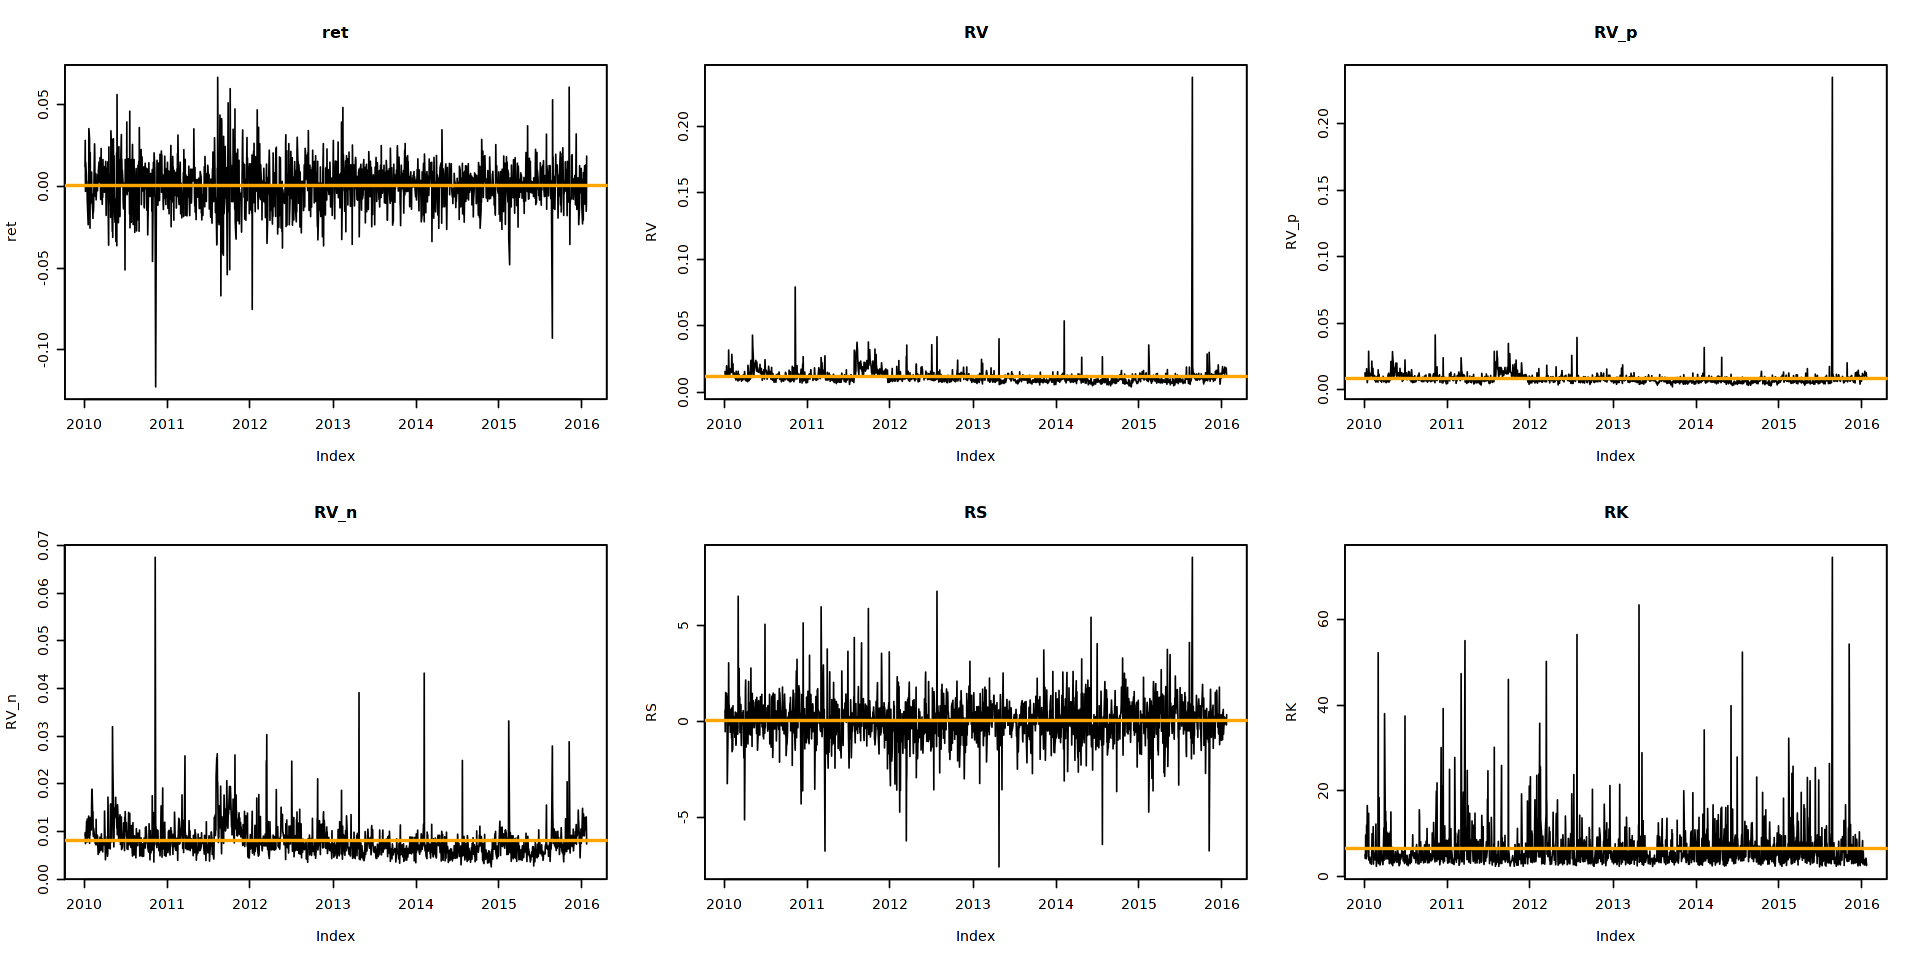

In [6]:
# Simple plot for each variable in aiz

par(mfrow = c(2, 3))
for (i in colnames(aiz)) {
  plot.zoo(aiz[, i], main = i, ylab = i)
  abline(h = mean(aiz[, i]), col = "orange", lwd = 2)
}


Firstly we note that the returns are more or less located around 0 which is also denoted by the orange line. The orange line in each graph represents the mean value of the variables. When looking at the volatility in particular, we note that there are 2 main negative jumps in the beginning and end of the returns and one more volatile period around the 25th quantile. With regards to the RV, we find it to be relatively stable except for a major spike towards the second half of 2015. Similarly, the same trend can be observed for RV_p.Note, that this jum surpasses a value of 0.2 and therefore it could have a big impact on our study later on. With regards to RV_n, smaller jumps are observed but the biggest jump can now be located in the beginning around the end of 2010. The RS plot, seemingly has a mean of around 0 as expected and the RK experiences a number of jumps with the largest in the second half of 2015 similarly to RV and RV_p. To have a more detailed look, we conduct the descriptive statistics below:

In [7]:
summary(aiz)

     Index                 ret                   RV          
 Min.   :2010-01-05   Min.   :-0.1225799   Min.   :0.004027  
 1st Qu.:2011-07-04   1st Qu.:-0.0072226   1st Qu.:0.008717  
 Median :2013-01-10   Median : 0.0009236   Median :0.010451  
 Mean   :2013-01-08   Mean   : 0.0007210   Mean   :0.011742  
 3rd Qu.:2014-07-14   3rd Qu.: 0.0090694   3rd Qu.:0.012951  
 Max.   :2016-01-22   Max.   : 0.0668321   Max.   :0.236732  
      RV_p               RV_n                RS                 RK        
 Min.   :0.002052   Min.   :0.002596   Min.   :-7.57509   Min.   : 2.277  
 1st Qu.:0.005994   1st Qu.:0.005920   1st Qu.:-0.59376   1st Qu.: 3.713  
 Median :0.007339   Median :0.007224   Median : 0.02967   Median : 4.920  
 Mean   :0.008268   Mean   :0.008095   Mean   : 0.02845   Mean   : 6.641  
 3rd Qu.:0.009228   3rd Qu.:0.009210   3rd Qu.: 0.66830   3rd Qu.: 7.201  
 Max.   :0.235076   Max.   :0.067553   Max.   : 8.52780   Max.   :74.501  

From these statistics, we find most observations from the plots above to be further suported. As, noted above, the returns have a mean of around 0. Moreover, we note that the positive RV mean is more or less the same as the negative RV. In addition we observe a positive mean and median for the RS variable.

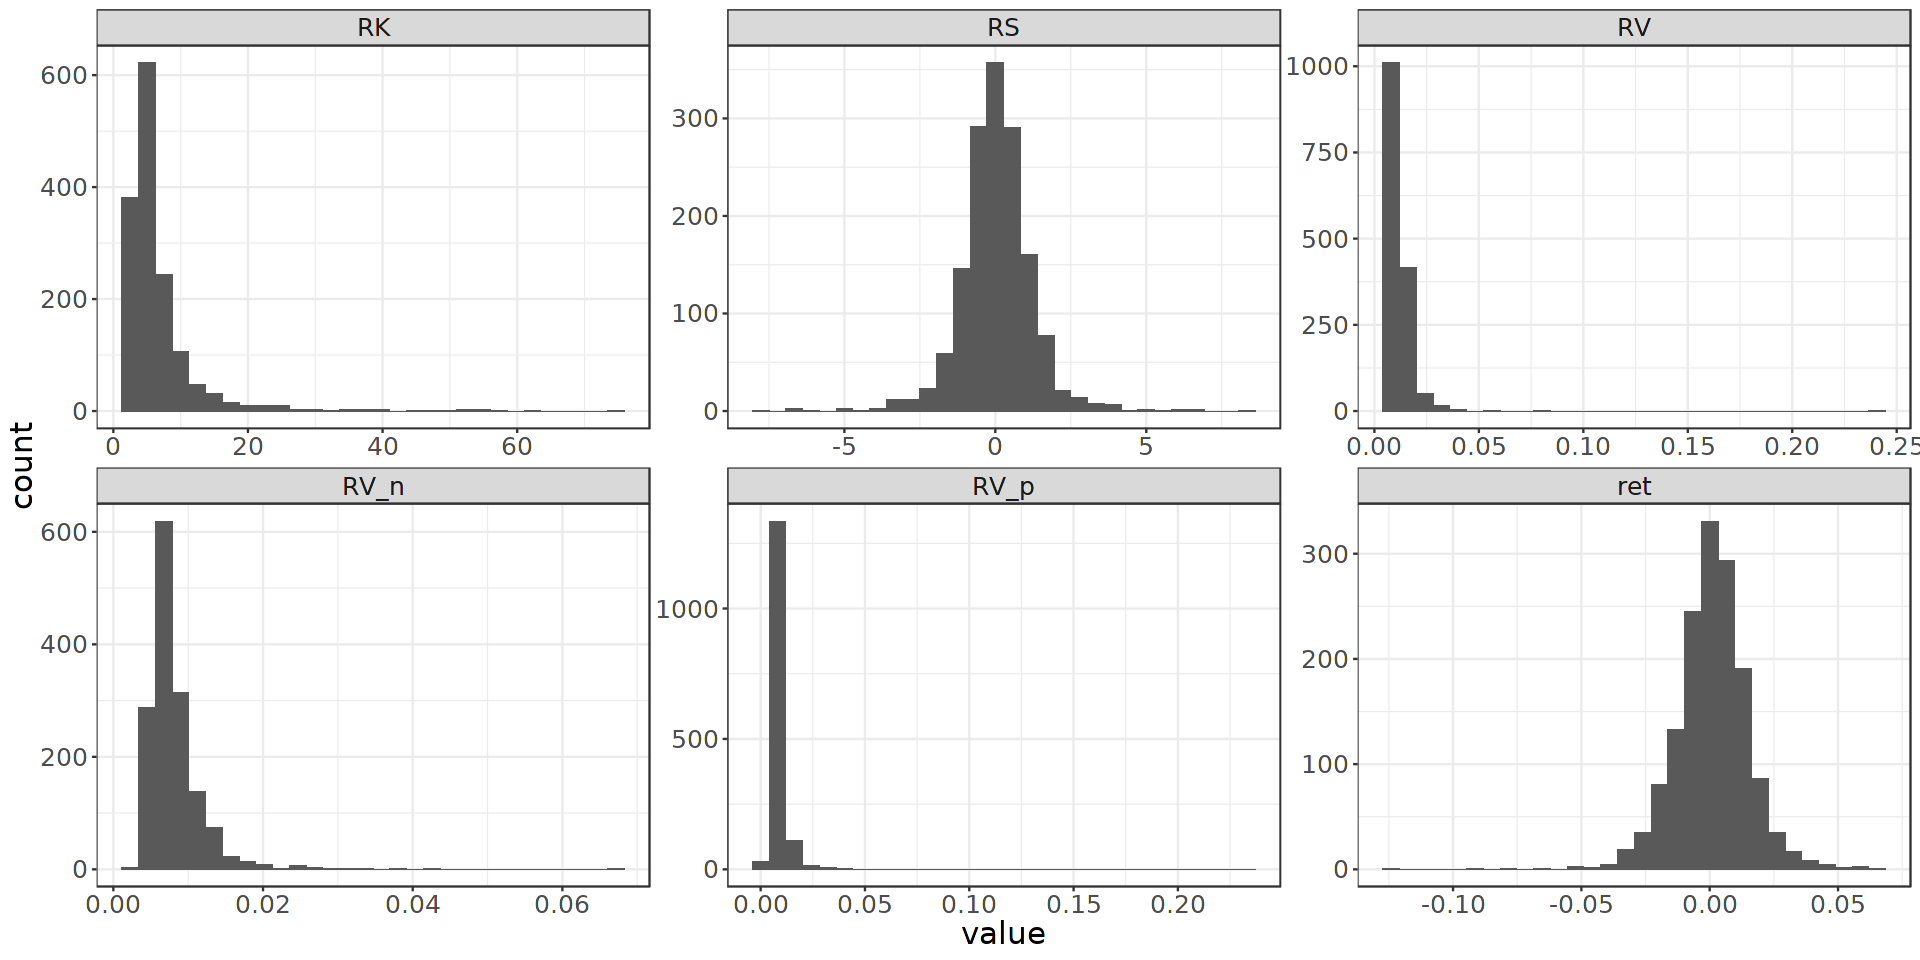

In [8]:
# Histograms of the distribution of each variable

aiz %>%
  as.data.frame() %>%
  gather() %>%
  ggplot(aes(value)) +
  facet_wrap(~key, scales = "free") +
  geom_histogram(bins = 30) +
  theme_bw() +
  theme(text = element_text(size = 18))

From the above histograms we check for the distribution of each variable. Namely we intuitively analyze the skewness or normality of the distributions. We can observe that are all noteably skewed except for the returns and RS variables. Since the returns are key to further analysis we will look at it's distribution in more detail using the Shapiro-Wilk normality test.

In [9]:
shapiro.test(as.numeric(aiz$ret))


	Shapiro-Wilk normality test

data:  as.numeric(aiz$ret)
W = 0.9517, p-value < 2.2e-16


From the above Shapiro-Wilk normality test, we find evidence that the returns are not normally distributed since the statistic counts .9517 with a statistically significant p-value. Moreover we will have a look at the ACF test for all variables to check for autocorrelation.

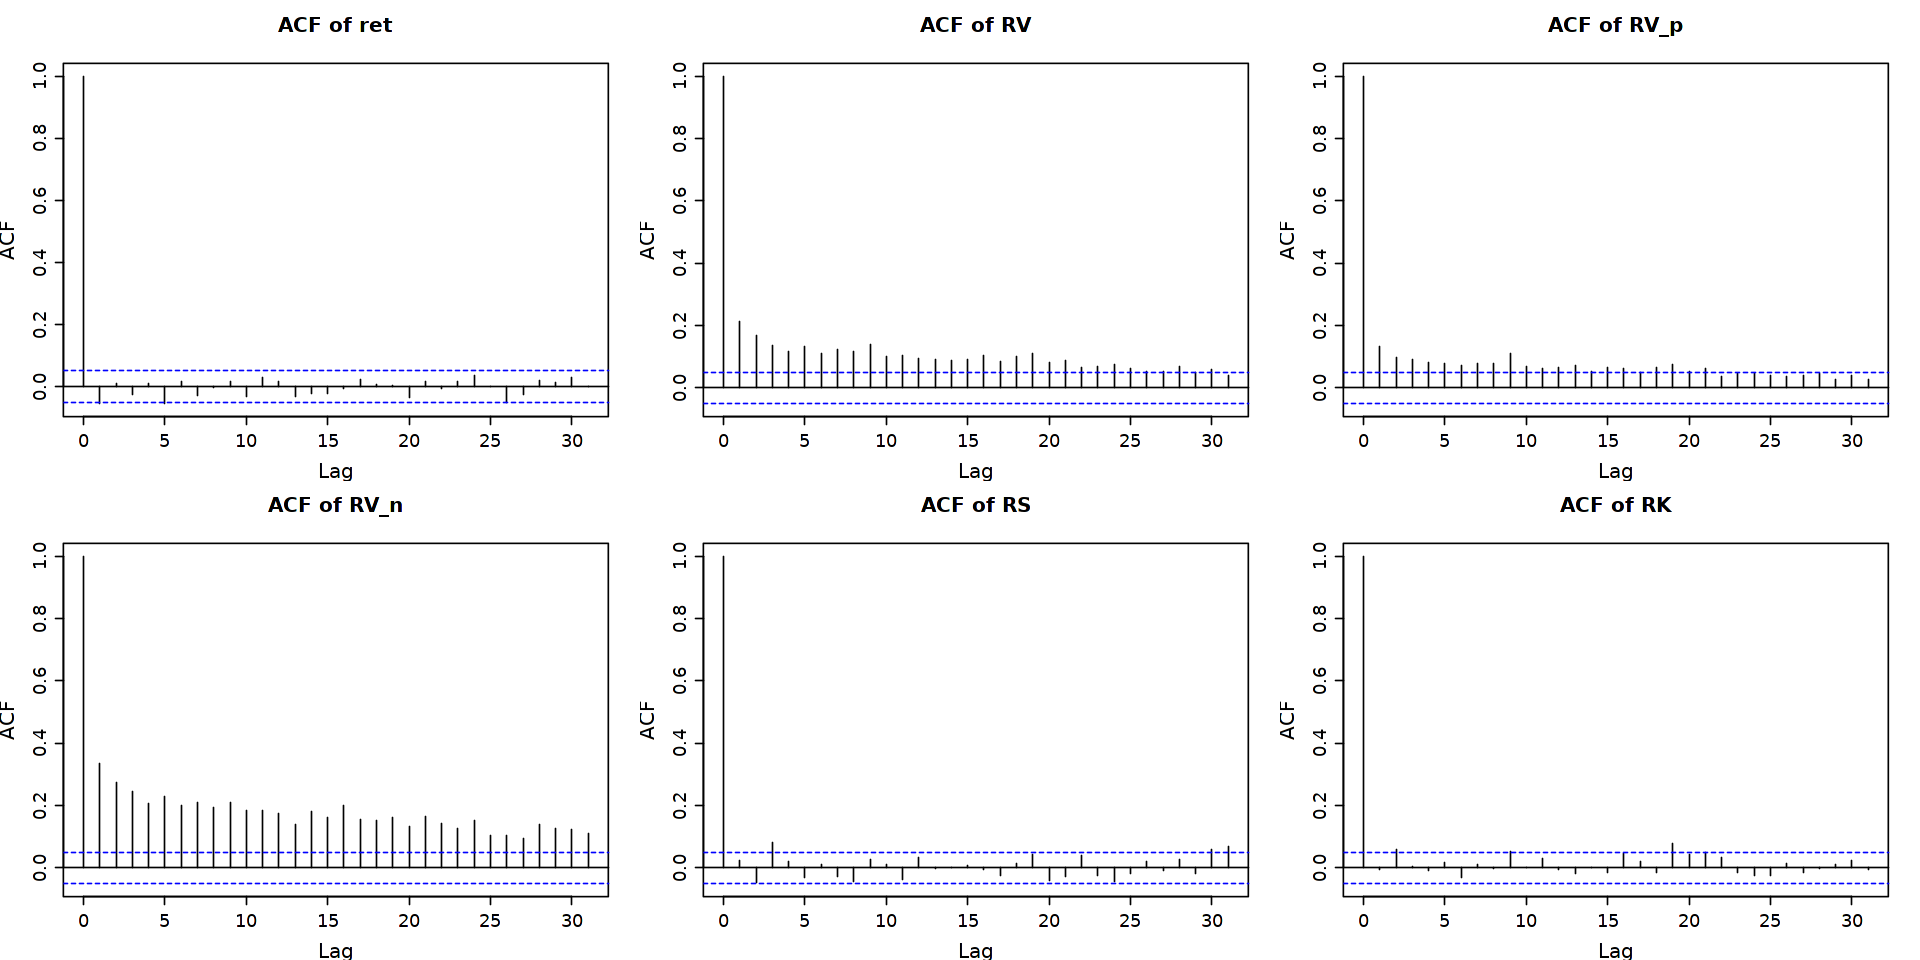

In [10]:
# ACF plot of each variable

par(mfrow = c(2, 3), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
for (i in colnames(aiz)) {
  acf(aiz[, i], main = paste("ACF of", colnames(aiz[, i])))
}


From the above ACF tests we find there to be a relatively low decay for RV, RV_p and RV_n suggesting a certain degree of autocorrelation. On the other hand, such observations are not found for ret, RS and RK, suggesting no dependence on previous observations in time for those variables. 

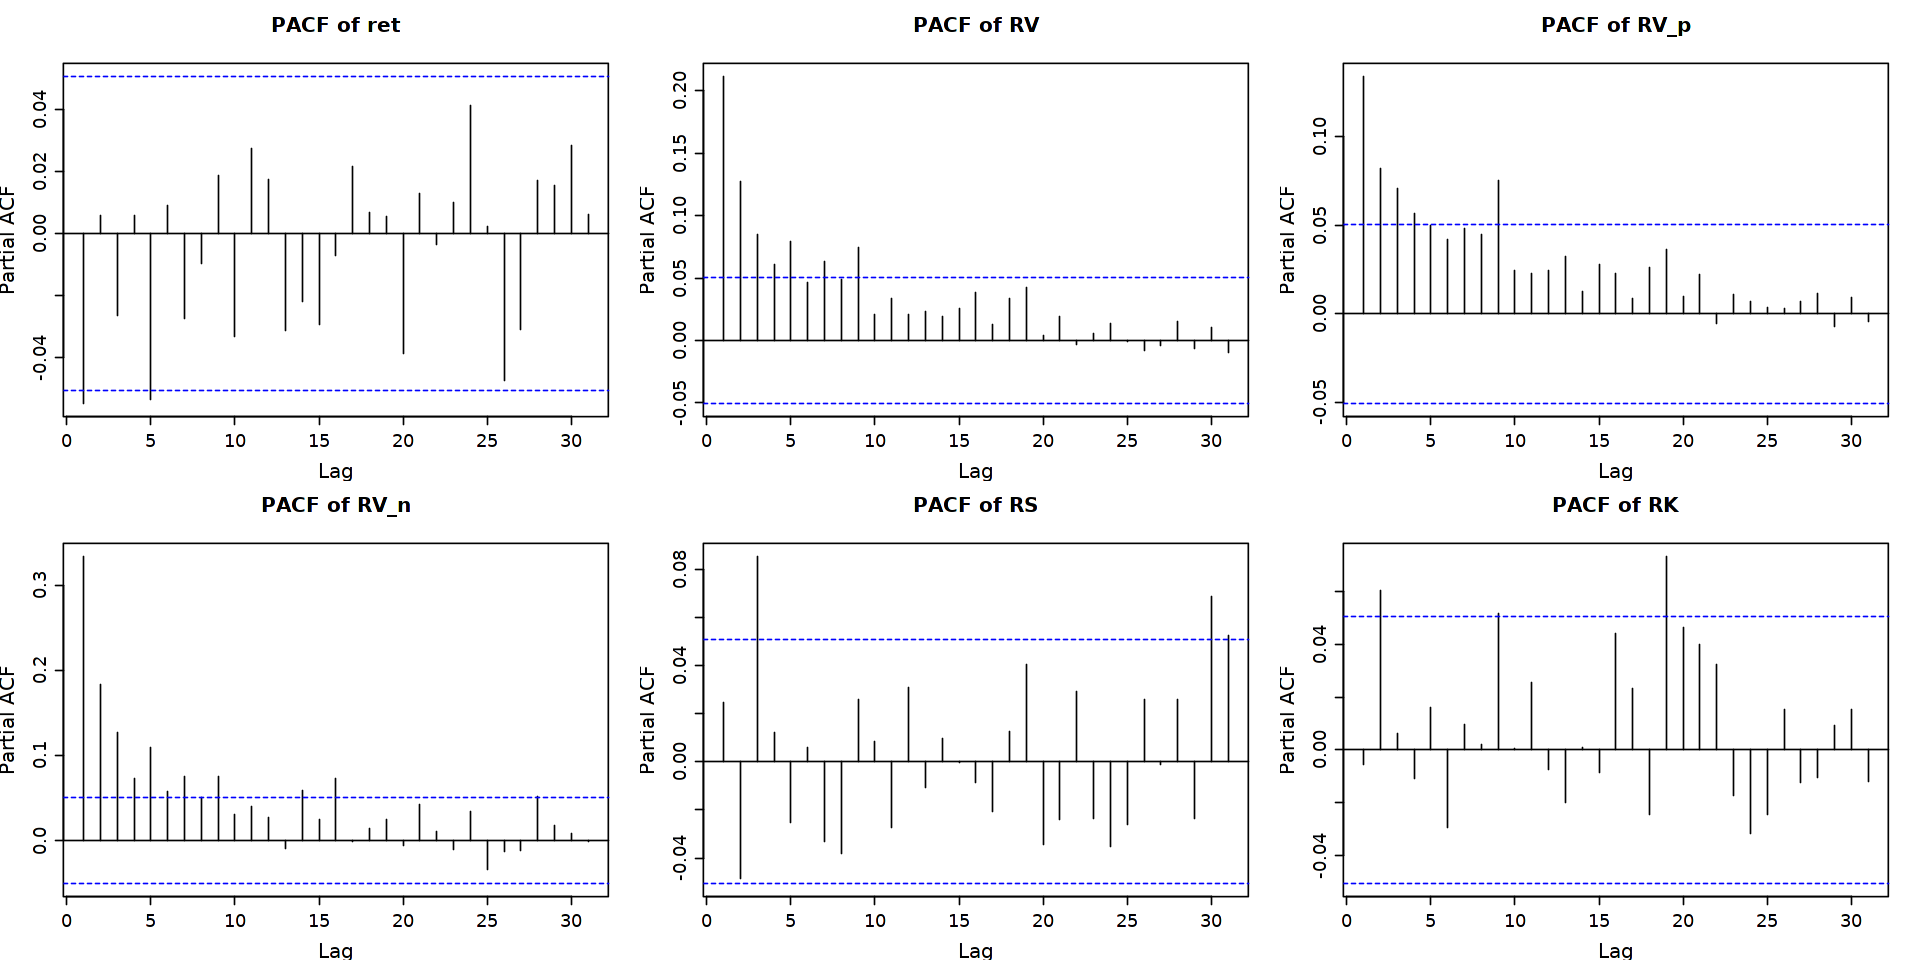

In [11]:
# PACF plot of each variable

par(mfrow = c(2, 3), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
for (i in colnames(aiz)) {
  pacf(aiz[, i], main = paste("PACF of", colnames(aiz[, i])))
}

## In-sample fit

### AR(1)-RV


This model can be denoted by the following formula:

$$ 
RV_t = \mu + \rho RV_{t-1}+u_t 
$$

for $t = 1, 2, ..., T$,
where $u_t \sim N(0, \sigma^2)$


Series: aiz$RV 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.2116  0.0117
s.e.  0.0252  0.0002

sigma^2 = 5.601e-05:  log likelihood = 5215.07
AIC=-10424.14   AICc=-10424.13   BIC=-10408.21

Training set error measures:
                       ME        RMSE         MAE       MPE     MAPE      MASE
Training set 2.762922e-07 0.007478906 0.003080213 -11.95805 25.90785 0.9343423
                    ACF1
Training set -0.02683008

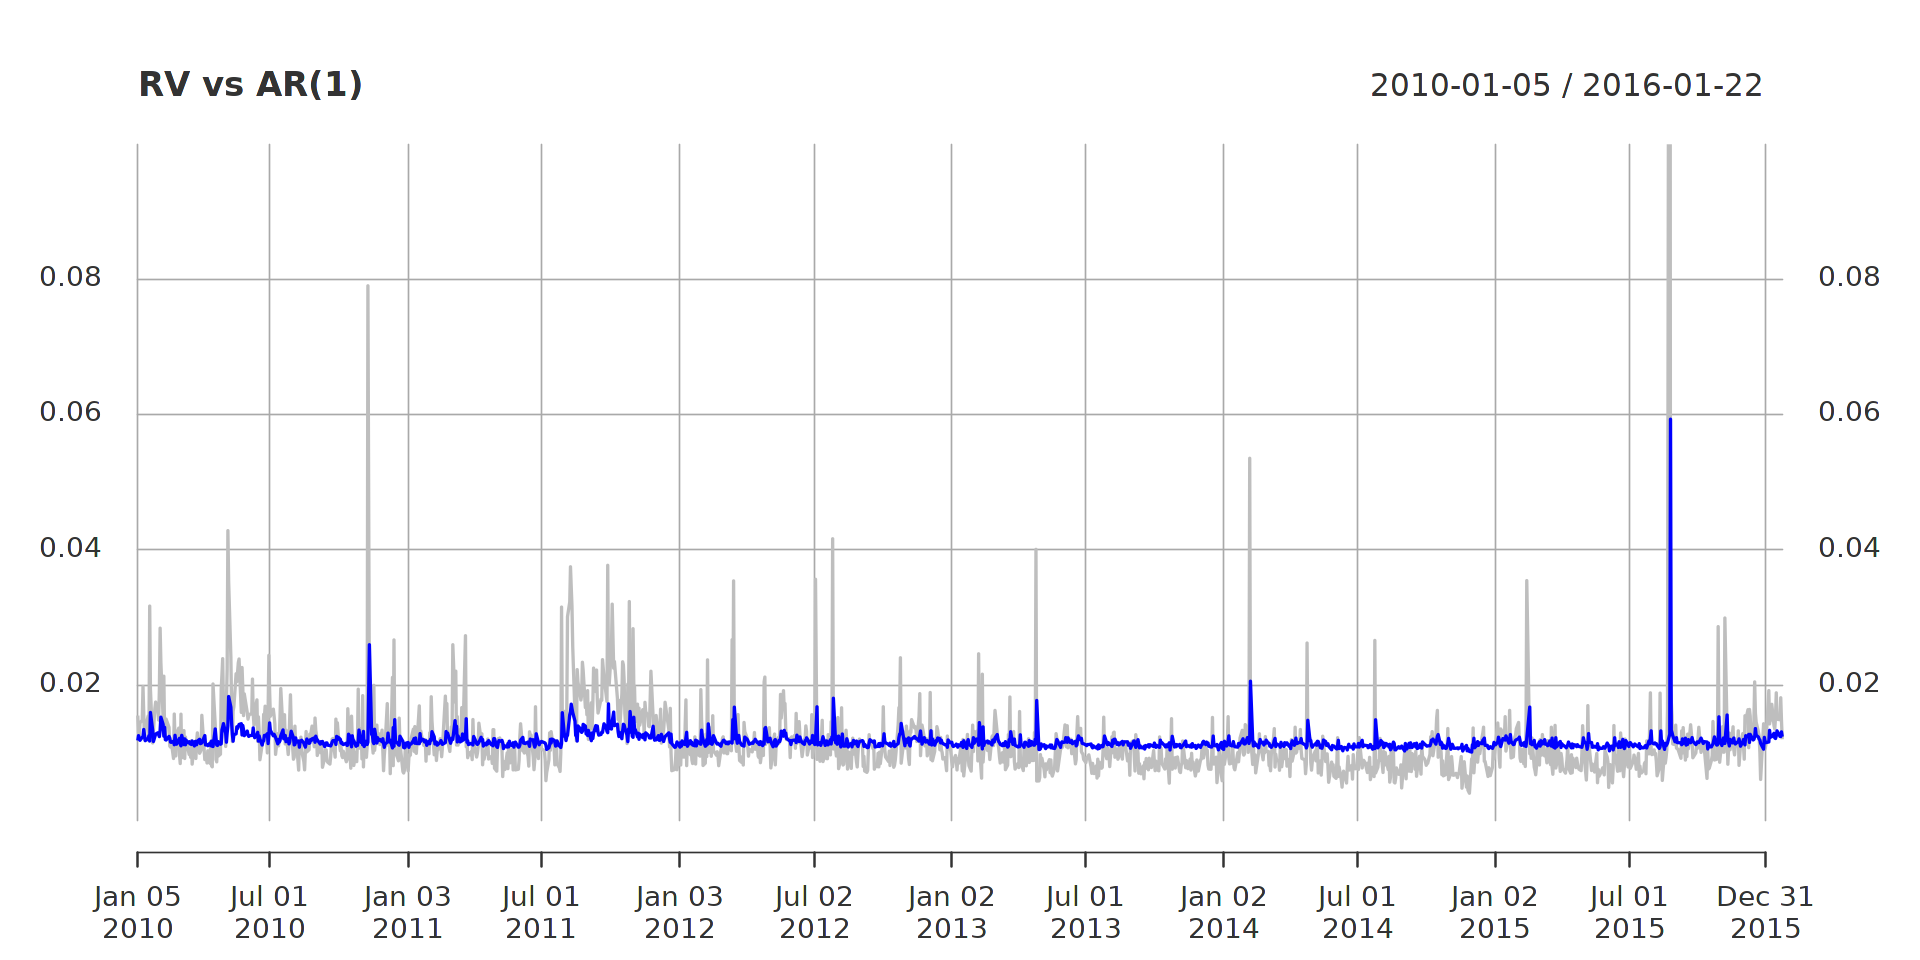

In [ ]:
ar1 <- Arima(aiz$RV, order = c(1, 0, 0))
summary(ar1)

ar1_fit <- xts(ar1$fitted, order.by = index(aiz$RV))

plot(
  merge(ar1_fit, aiz$RV),
  main = "RV vs AR(1)",
  col = c("blue", "gray"),
  lwd = 2,
  legend.loc = "top",
  cex = 1,
  ylim = c(0, 0.1)
)

The findings from the AR(1) model suggest that the coefficient of the first lag is positive and statistically significant with a given value of 0.2116. However, one ought to take into consideration the nature of the RV variable with regards to autocorrelation. Henceforth the first lag might not be sufficient for which we will incorporate additional lags in the model for the following HAR (High Autoregressive) approach. Thus, we believe that including more lags would improve the model's performance in capturing the dynamics of the data. Please note that in this graph and the following graphs we used a ylim argumant as the extreme spike in the summer of 2015 causes the remainder of the plot to be unclear.

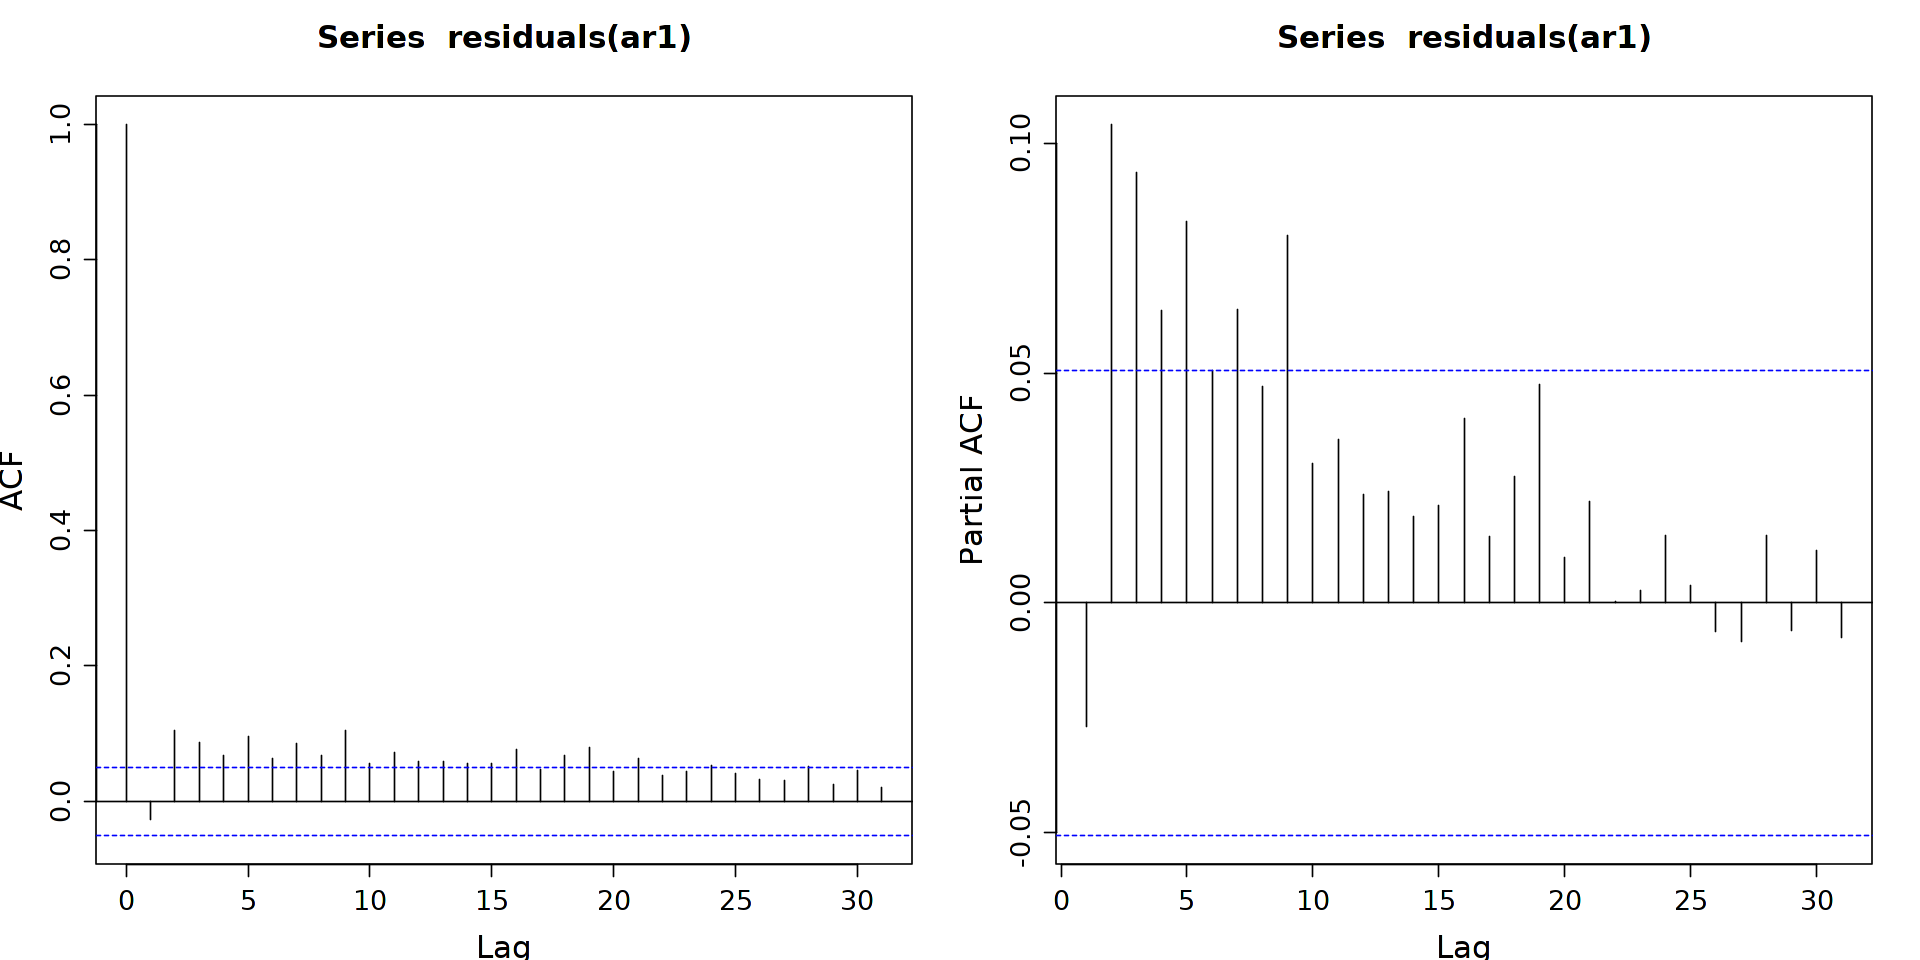

In [ ]:
par(mfrow = c(1, 2), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf(residuals(ar1))
pacf(residuals(ar1))

These predictions are further supported in the above acf and pacf test of the residuals of our fitter ar(1) model. Namely, there is still a strong degree of autocorrelation observable which needs to be studied in more detail.

### HAR

The Heterogeneous Autoregressive (HAR) model can be denoted mathematically as:
$$
RV_t = \beta_0 + \beta_1 RV_{t-1} + \beta_2 RV_{t-1}^{(5)} + \beta_3 RV_{t-1}^{(22)} + u_t
$$
for $t = 1, 2, ..., T$,
where $RV_{t-1}^{(5)}$ and $RV_{t-1}^{(22)}$ denote the averages of the weekly and monthly RV's,
and where $u_t \sim N(0, \sigma^2)$

Please note as mentioned earlier that since we are working with workday intervals of our data we used 5 and 22 respectively to note days and months. Henceforth we will have to specify these variables below:

In [ ]:
TT <- length(aiz$RV)
RV5 <- unlist(
  lapply(
    lapply(1:(TT - 4), function(t) {
      return(aiz$RV[t:(t + 4)])
    }),
    mean
  )
)
RV22 <- unlist(
  lapply(
    lapply(1:(TT - 21), function(t) {
      return(aiz$RV[t:(t + 21)])
    }),
    mean
  )
)
T5 <- length(RV5)
T22 <- length(RV22)
har_data <- as.data.frame(
  cbind(
    as.numeric(aiz$RV[23:TT]),
    as.numeric(aiz$RV[22:(TT - 1)]),
    RV5[18:(T5 - 1)],
    RV22[1:(T22 - 1)],
    as.numeric(aiz$RV_n[22:(TT - 1)]),
    as.numeric(aiz$RV_p[22:(TT - 1)]),
    as.numeric(aiz$RK[22:(TT - 1)]),
    as.numeric(aiz$RS[22:(TT - 1)])
  )
)
colnames(har_data) <- c("rv_t0", "rv_t1", "rv5", "rv22", "rvn", "rvp", "rk", "rs")
har_data_ts <- ts(har_data)

Once we specified the variables we will implement those variables in the application of the HAR model using the tslm() command from the forecast package.


Call:
tslm(formula = rv_t0 ~ rv_t1 + rv5 + rv22, data = har_data_ts)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.023995 -0.002303 -0.000900  0.000990  0.225132 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0037826  0.0007379   5.126 3.35e-07 ***
rv_t1       0.0933680  0.0299317   3.119  0.00185 ** 
rv5         0.1488679  0.0650216   2.290  0.02219 *  
rv22        0.4326698  0.0830097   5.212 2.13e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007322 on 1474 degrees of freedom
Multiple R-squared:  0.08964,	Adjusted R-squared:  0.08779 
F-statistic: 48.38 on 3 and 1474 DF,  p-value: < 2.2e-16


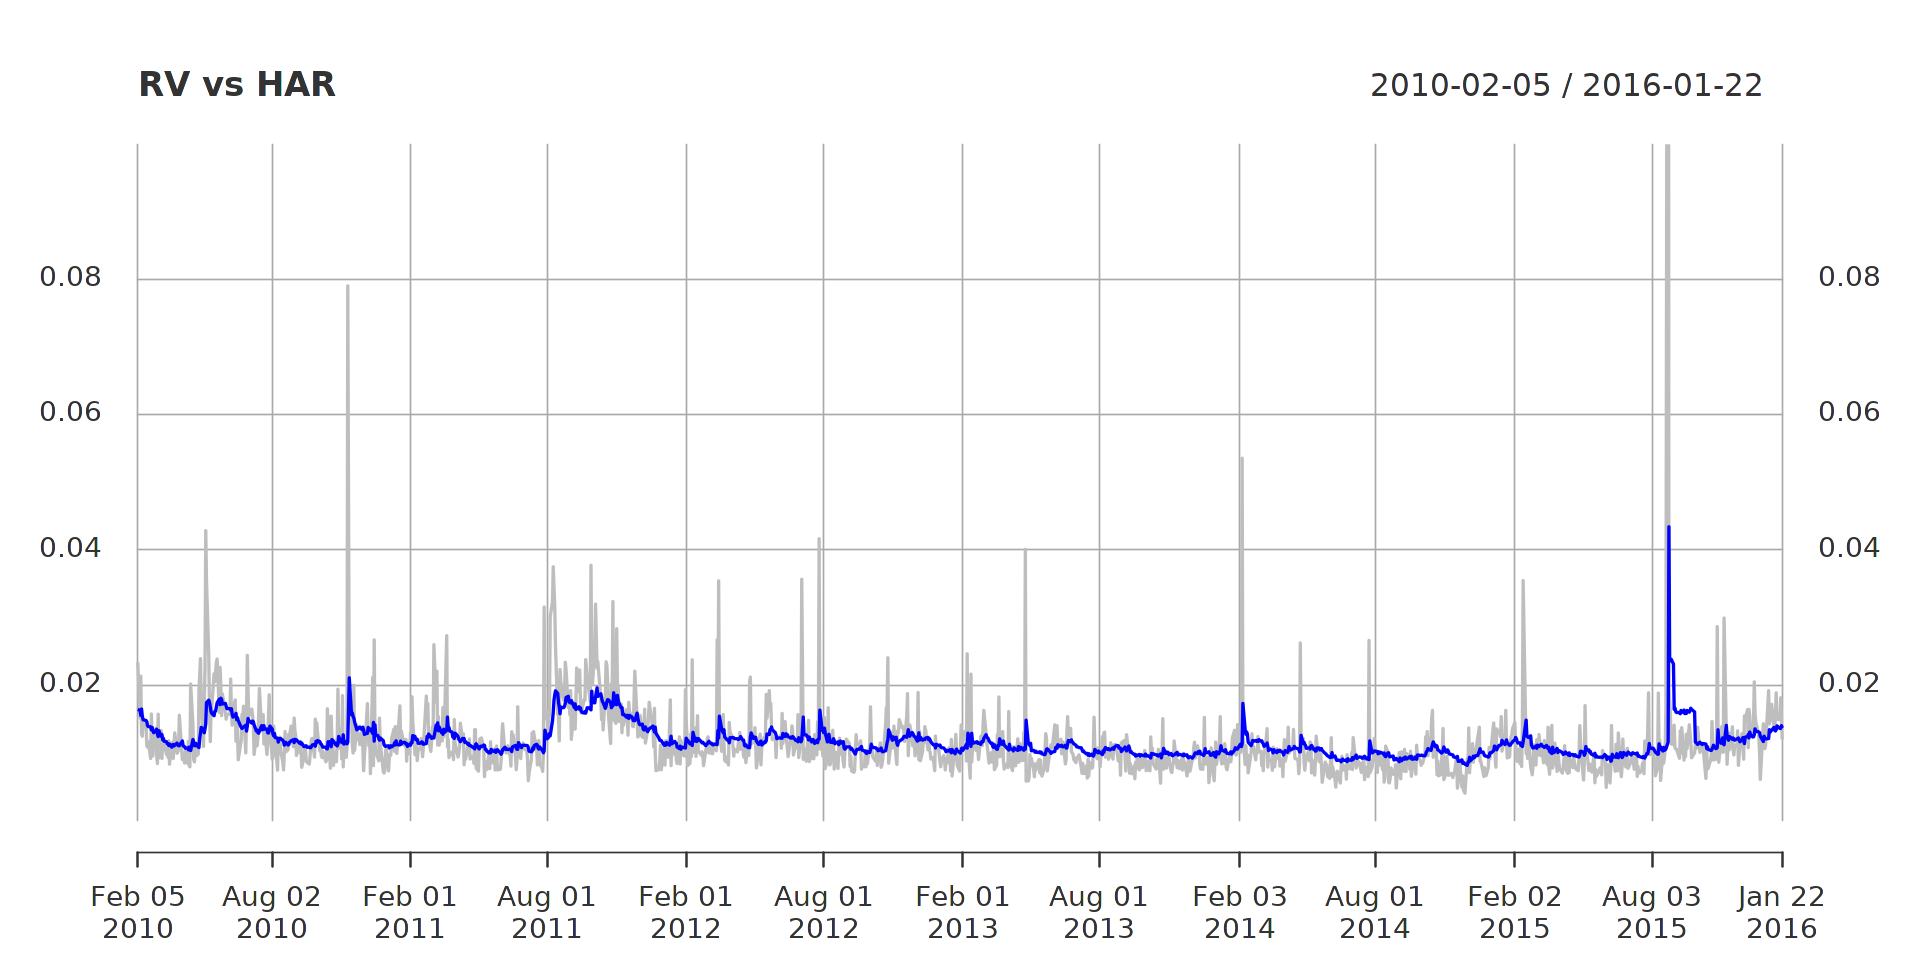

In [ ]:
har <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22, data = har_data_ts)
summary(har)

har_fit <- xts(fitted(har), order.by = index(aiz$RV[23:TT]))

plot(
  merge(har_fit, aiz$RV[23:TT]),
  main = "RV vs HAR",
  col = c("blue", "gray"),
  lwd = 2,
  legend.loc = "top",
  cex = 1,
  ylim = c(0, 0.1)
)

The analysis reveals that the coefficient for the monthly RV is the most economically significant among the three coefficients, excluding the intercept, counting 0.4326698. Additionally, both the coefficients for the weekly and 1st lag effects demonstrate economic and statistical significance. However, the monthly coefficient holds greater economic and statistical significance compared to the weekly coefficient. This suggests that investors are more likely to engage in trading the stock on a monthly basis rather than on a weekly basis.

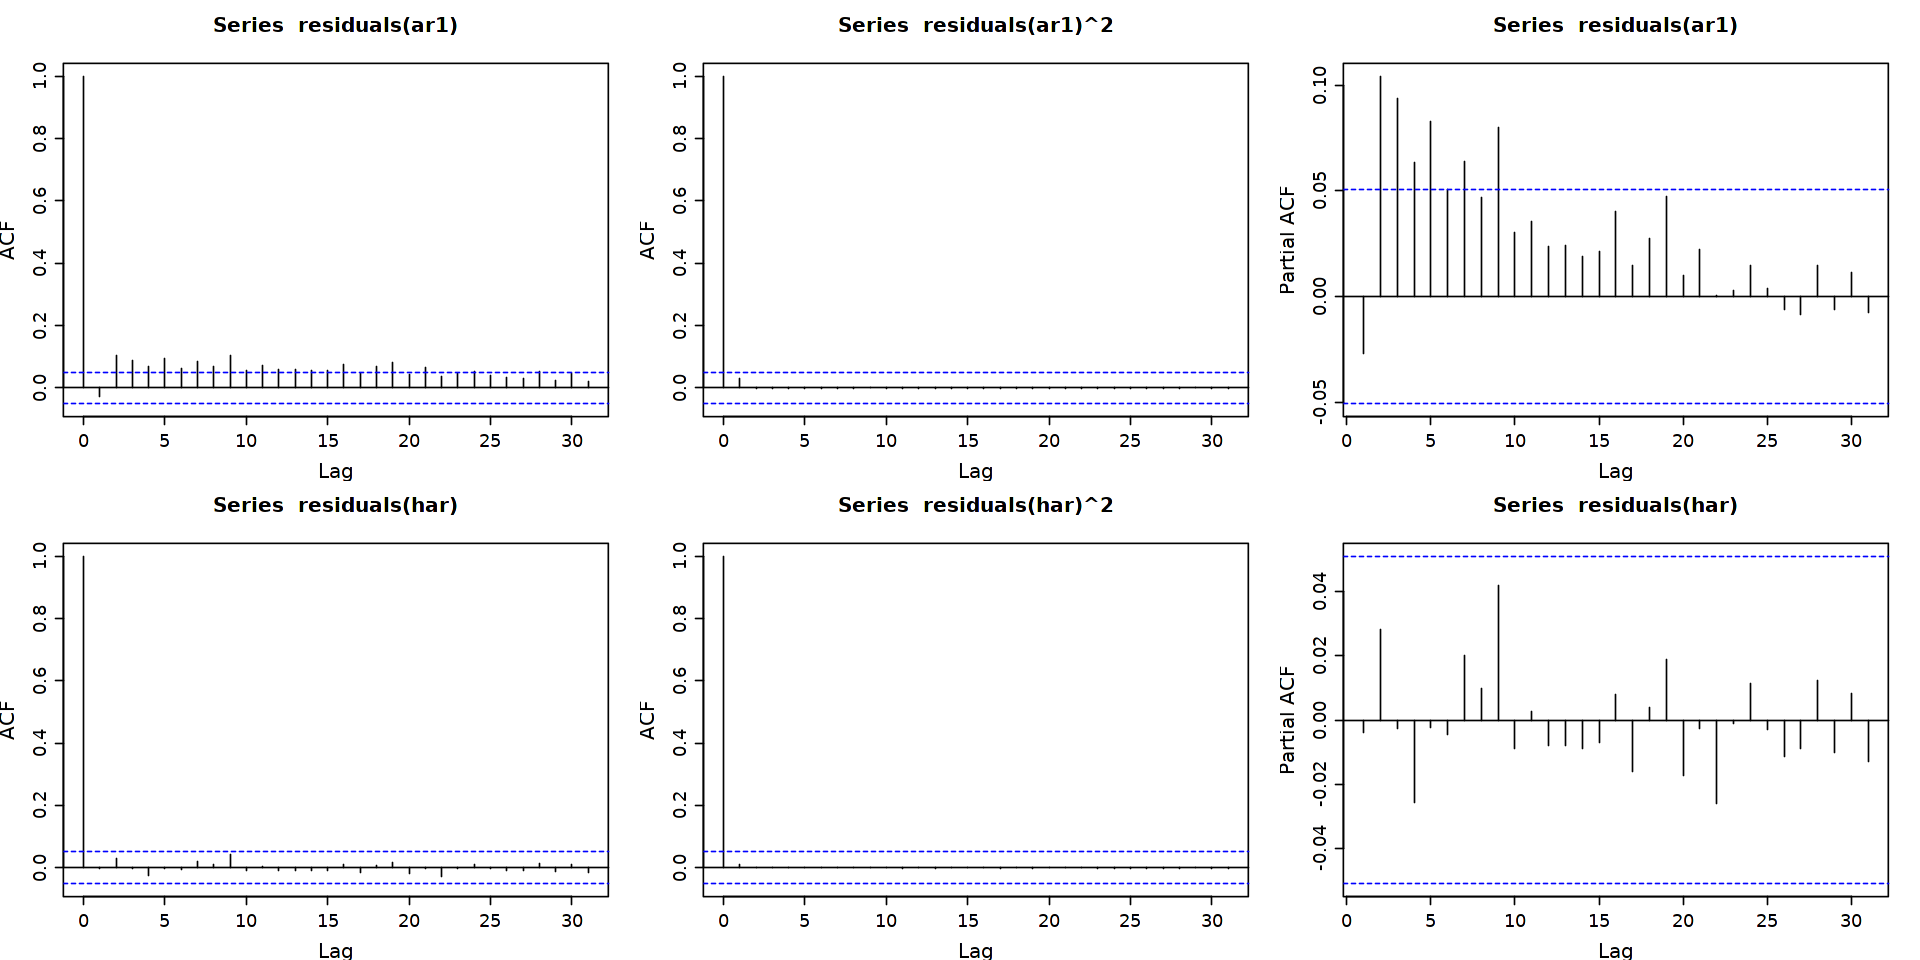

In [ ]:
par(mfrow = c(2, 3), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf(residuals(ar1))
acf(residuals(ar1)^2)
pacf(residuals(ar1))
acf(residuals(har))
acf(residuals(har)^2)
pacf(residuals(har))

Upon comparing the autocorrelation functions (ACFs) and partial autocorrelation functions (PACFs) of both the AR (autoregressive) and HAR (Heterogeneous Autoregressive) models, it is evident that the HAR model outperforms the AR model in capturing the relationship. The ACF and PACF plots of the HAR model indicate minimal residual dependence, indicating a more successful modeling of the relationship between the variables.

### HAR-RS

The HAR-RS model divides the impact of realized volatility (RV) into positive and negative semi-volatility, leading to the following equation:

$$ RV_t = \beta_0 + \beta_1^+RS^+{t-1} + \beta_1^-RS^-{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + u_t\ \ \ \ \text{for} \ t=1,2,...,T $$


Call:
tslm(formula = rv_t0 ~ rvn + rvp + rv5 + rv22, data = har_data_ts)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.015859 -0.002233 -0.000858  0.001002  0.224382 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0033816  0.0007396   4.572 5.22e-06 ***
rvn         0.2901158  0.0588214   4.932 9.06e-07 ***
rvp         0.0245954  0.0329572   0.746    0.456    
rv5         0.1071519  0.0652663   1.642    0.101    
rv22        0.3846267  0.0832207   4.622 4.14e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007278 on 1473 degrees of freedom
Multiple R-squared:  0.1012,	Adjusted R-squared:  0.09873 
F-statistic: 41.45 on 4 and 1473 DF,  p-value: < 2.2e-16


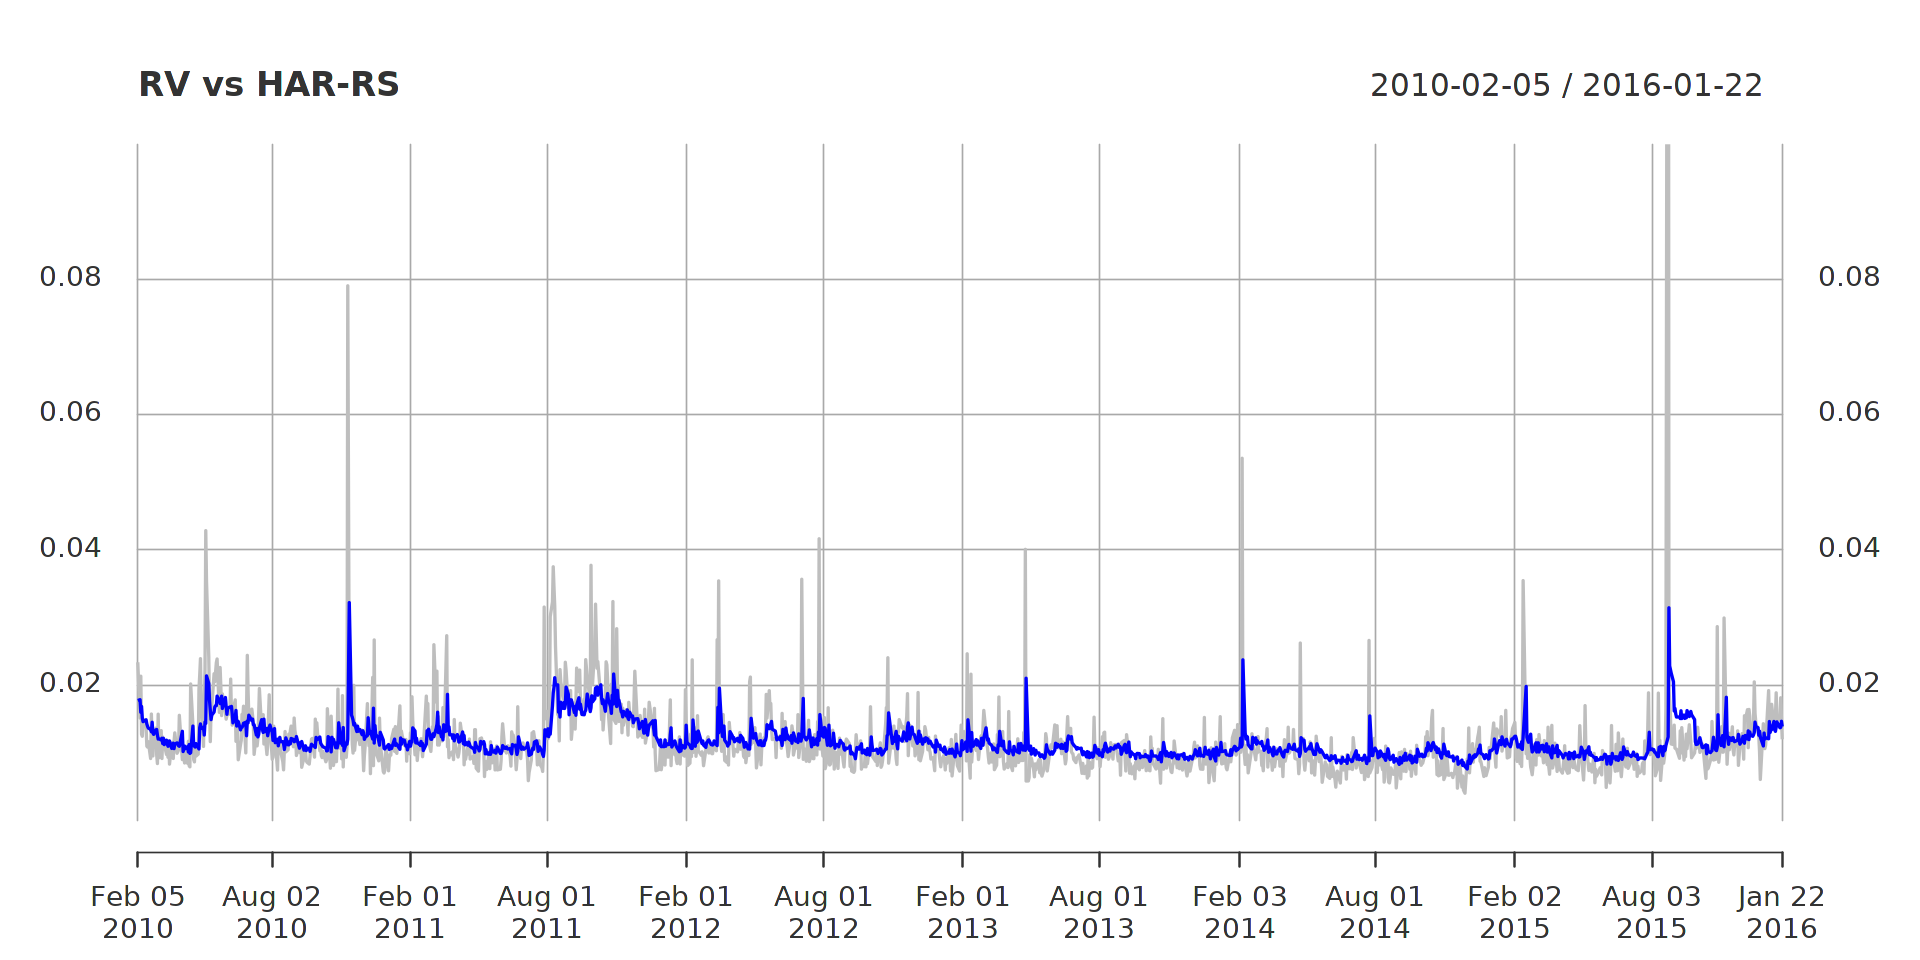

In [ ]:
har_rs <- tslm(rv_t0 ~ rvn + rvp + rv5 + rv22, data = har_data_ts)

summary(har_rs)

har_rs_fit <- xts(fitted(har_rs), order.by = index(aiz$RV[23:TT]))

plot(
  merge(har_rs_fit, aiz$RV[23:TT]),
  main = "RV vs HAR-RS",
  col = c("blue", "gray"),
  lwd = 2,
  legend.loc = "top",
  cex = 1,
  ylim = c(0, 0.1)
)

By splitting the effect of the first lag of realized volatility (RV) into positive and negative semi-volatility, we obtain distinct estimates for each of these measures. In comparison to the previous model, it is evident that the coefficient for negative semi-volatility (RV_n) is much greater in magnitude to the coefficient for RV_p.

The coefficient for RV_n appears to hold greater economic significance than the coefficient for RV_p. In fact, RV_p is estimated to be not statistically significant. To test this observation, we conduct a similar regression but include an interaction term that captures the difference between the two semi-volatilities. The purpose of this interaction term is to assess whether the difference is statistically significant, which would indicate the presence of a leverage effect.

Regarding the coefficients for weekly and monthly effects, they remain relatively consistent in terms of both economic and statistical significance compared to the standard HAR model for motnhly RV but for weekly RV we now observe no statistical significance. Additionally, both the R-squared and adjusted R-squared values have increased slightly or remained stable compared to the standard HAR model, indicating a potentially improved fit.

In [ ]:
har_rs_test <- tslm(rv_t0 ~ I(rvn - rvp) + rv5 + rv22, data = har_data_ts)
summary(har_rs_test)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.00378238,0.0007423756,5.0949681,3.938871e-07
I(rvn - rvp),0.02715066,0.0317600843,0.8548675,3.927634e-01
rv5,0.25099560,0.0598773820,4.1918265,2.931725e-05
rv22,0.42428732,0.0836382331,5.0728872,4.415853e-07


As illustrated above, we conducted a test to determine whether the difference between the coefficients of the two semi-volatilities is statistically significant. Our results indicate that the difference is indeed significant, with a positive coefficient for the term interaction term. This confirms the presence of a leverage effect in our data. To explore this further we can have a look at the acf plots of both RV_p and RV_n.

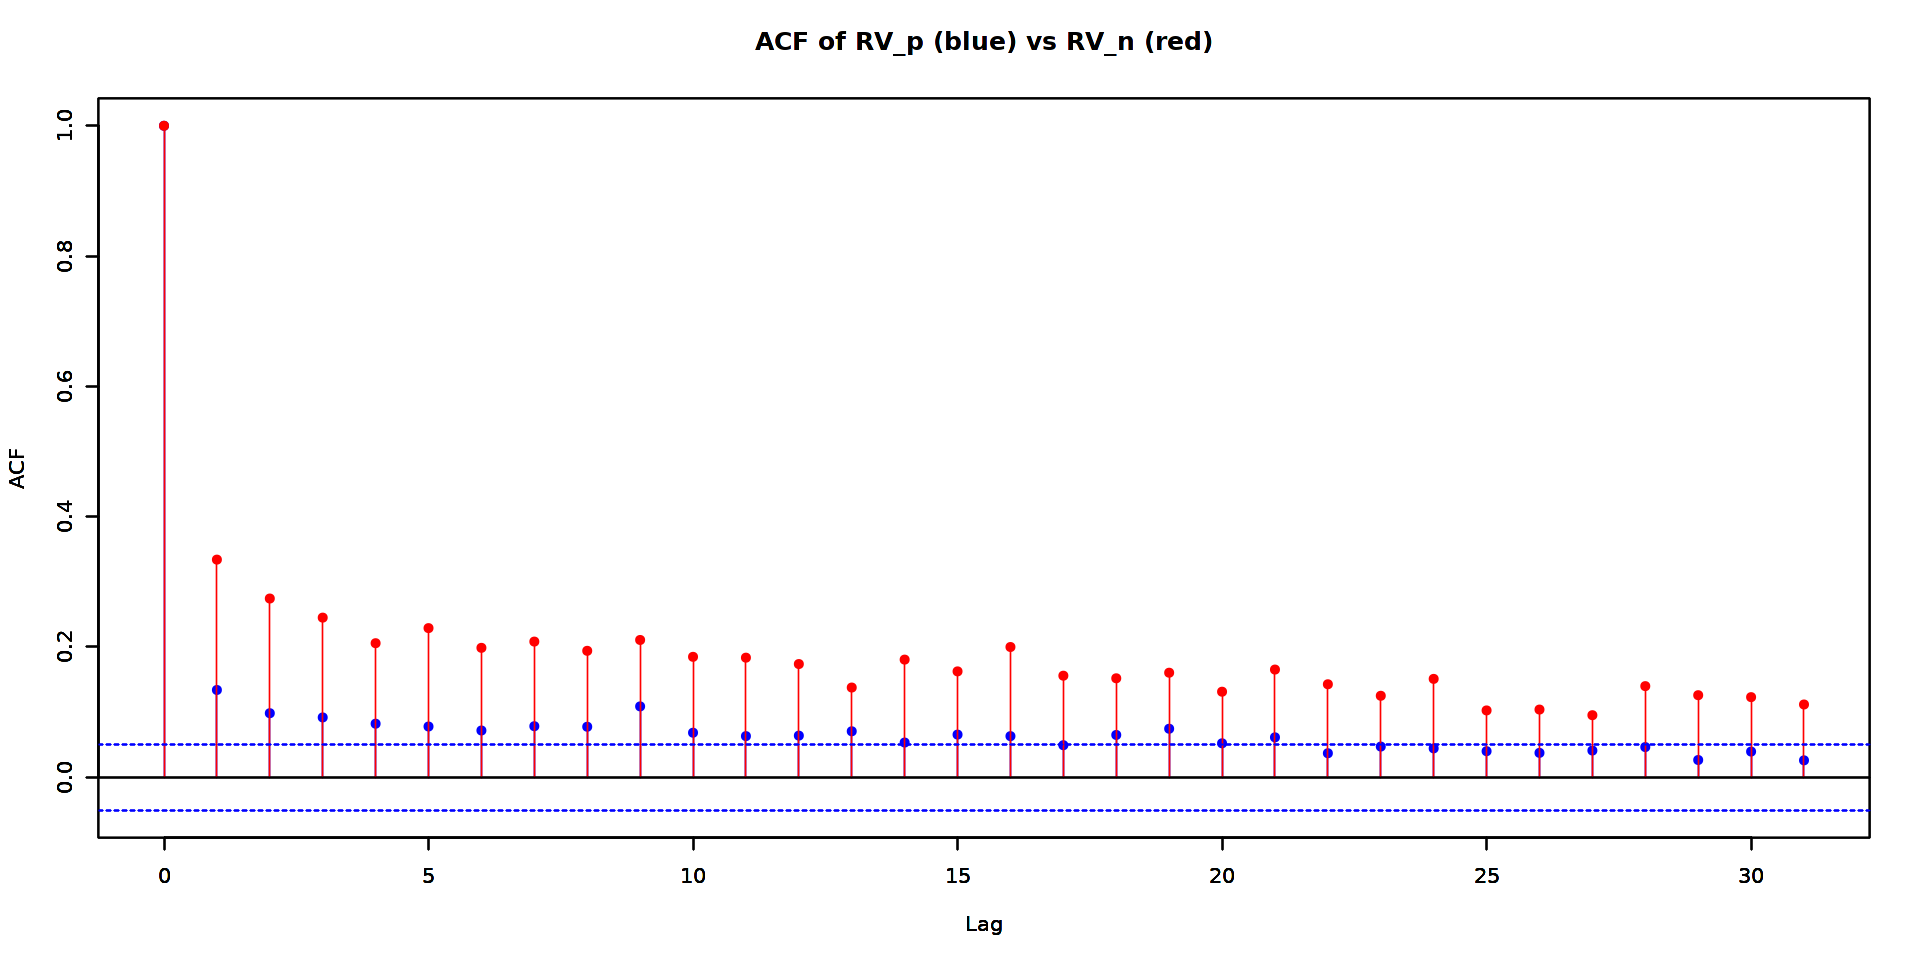

In [ ]:
plot(acf(aiz$RV_p, plot = F), type = "h", col = "blue", main = "ACF of RV_p (blue) vs RV_n (red)")
par(new = T)
plot(acf(aiz$RV_p, plot = F), type = "p", col = "blue", pch = 16, main = "")
par(new = T)
plot(acf(aiz$RV_n, plot = F), type = "h", col = "red", main = "")
par(new = T)
plot(acf(aiz$RV_n, plot = F), type = "p", col = "red", pch = 16, main = "")

In our analysis, we found that the persistence of positive and negative semi-volatility is initially very similar in pattern. However, there is a persistent gap between both throughout all lags and therefore we can consider it to be significant. This observation suggests that the presence of the leverage effect in our data is supported and we should henceforth take this into account when analzying the models at hand. In other words, based on the ACF plots, it appears that negative realized semi-volatility provides significantly different information for forecasting realized volatility compared to positive realized semi-volatility. Moreover, the "leverage effect" refers to a phenomenon where negative or adverse events have a greater impact on volatility compared to positive events of the same magnitude. It suggests that there is asymmetry in the relationship between volatility and market returns. Specifically, in the presence of a leverage effect, negative shocks or volatility increases have a larger effect on future volatility compared to positive shocks or volatility increases of the same magnitude. 

### HAR-Rskew-Rkurt

By incorporating realized skewness and kurtosis into the HAR equation, we aim to capture the influence of jumps in the data. This leads to an expanded model with additional terms, which can be expressed as follows:
$$
RV_t = \beta_0 + \beta_1RV_{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + \beta_4RSkew_{t-1} + \beta_5RKurt_{t-1} + u_t \ \ \ \ \text{for} \ t=1,2,...,T
$$

where $u_t \sim N(0,\sigma^2)$, $RSkew_{t}=\sqrt m \frac{\sum^m_{j=1}r^3_{t-1+jn}}{RV_t^{3/2}}$, and $RKurt_{t}=\sqrt m \frac{\sum^m_{j=1}r^4_{t-1+jn}}{RV_t^{2}}$.


Call:
tslm(formula = rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = har_data_ts)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.027074 -0.002309 -0.000907  0.000943  0.224357 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.753e-03  7.688e-04   6.183 8.14e-10 ***
rv_t1        1.597e-01  3.371e-02   4.738 2.37e-06 ***
rv5          1.259e-01  6.489e-02   1.940   0.0526 .  
rv22         3.926e-01  8.309e-02   4.725 2.53e-06 ***
rk          -1.516e-04  3.556e-05  -4.264 2.14e-05 ***
rs          -1.940e-05  1.528e-04  -0.127   0.8990    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007282 on 1472 degrees of freedom
Multiple R-squared:  0.1008,	Adjusted R-squared:  0.0977 
F-statistic: 32.98 on 5 and 1472 DF,  p-value: < 2.2e-16


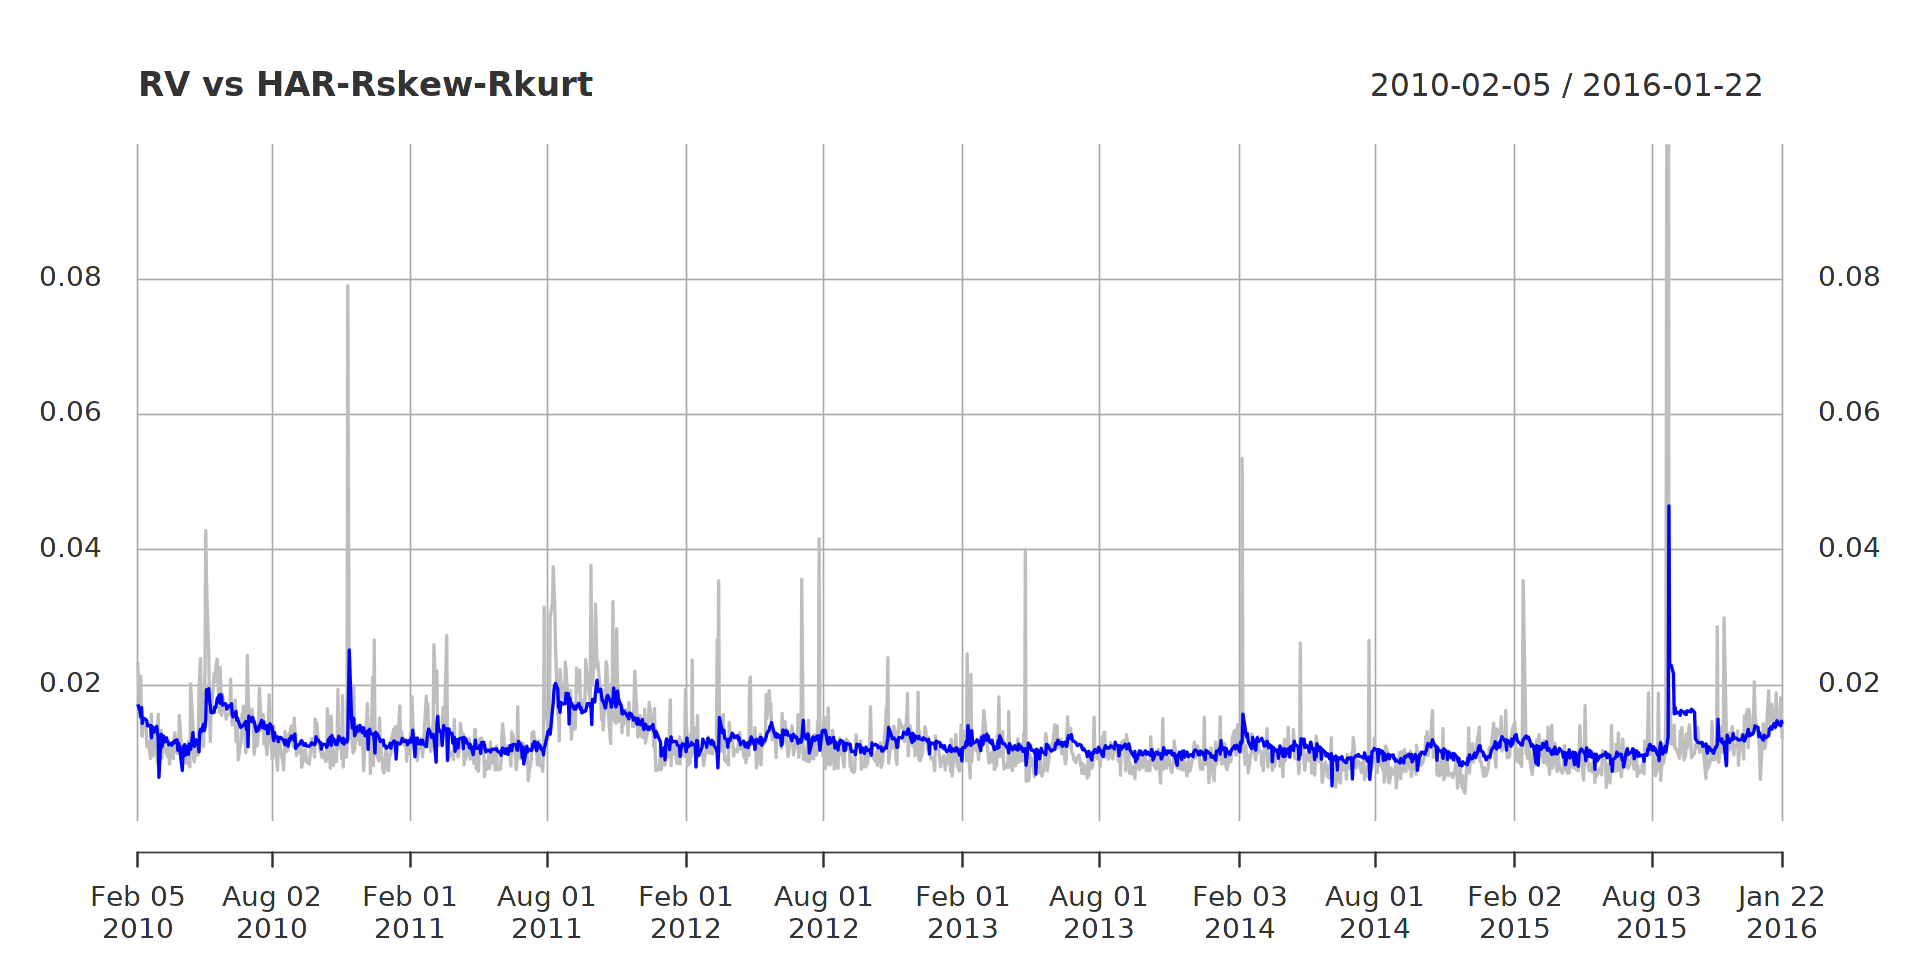

In [ ]:
har_skew_kurt <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = har_data_ts)

summary(har_skew_kurt)

har_skew_kurt_fit <- xts(fitted(har_skew_kurt), order.by = index(aiz$RV[23:TT]))

plot(
  merge(har_skew_kurt_fit, aiz$RV[23:TT]),
  main = "RV vs HAR-Rskew-Rkurt",
  col = c("blue", "gray"),
  lwd = 2,
  legend.loc = "top",
  cex = 1,
  ylim = c(0, 0.1)
)

When examining the HAR-family models, we observe that the R-squared and adjusted R-squared values are slightly lower compared to the previously conducted HAR-RS model but still higher than the standard HAR model. The coefficient of the first lag (RV) shows a slight increase compared to the standard HAR model. However, the coefficients for the weekly and monthly effects show a slight decrease in their economic significance. In addition, the weekly RV is also statisticallyinsignificant which ought to be taken into consideration. Interestingly, the coefficient for realized kurtosis (RK) is unexpectedly negative and statistically significant, which is contrary to our expectations of either no relationship or a significantly positive one. Conversely, the coefficient for realized skewness (RS) is found to be insignificant.

### Realized GARCH

Realized GARCH is implemented to improve the modeling and forecasting of volatility in financial time series data by incorporating realized volatility measures. It captures the time-varying nature of volatility and can be represented as:

$$r_t = \sqrt{h_t} z_t $$
$$ log(h_t) = \alpha_0 + \alpha_1 log(x_{t-1}) + \beta_1log(h_{t-1}) $$
$$ log(x_t) = \xi + \psi log(h_t) + u_t \ \ \ \ \text{for} \ t=1,2,...,T$$
where $z_t\sim N(0,1)$, $u_t \sim N(0, \sigma^2)$, and $x_t$ is a realized measure of volatility.


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: realGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000828    0.000305   2.7176 0.006575
omega   0.963861    0.271454   3.5507 0.000384
alpha1  1.000000    0.163007   6.1347 0.000000
beta1   0.591425    0.065736   8.9970 0.000000
eta11  -0.024282    0.007221  -3.3629 0.000771
eta21   0.038144    0.004001   9.5328 0.000000
delta   0.310124    0.020706  14.9774 0.000000
lambda  0.265886    0.005091  52.2274 0.000000
xi     -1.820321    0.178707 -10.1860 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000828    0.000314   2.6364 0.008378
omega   0.963861    0.720333   1.3381 0.180871
alpha1  1.000000    0.622843   1.6055 0.108375
beta1

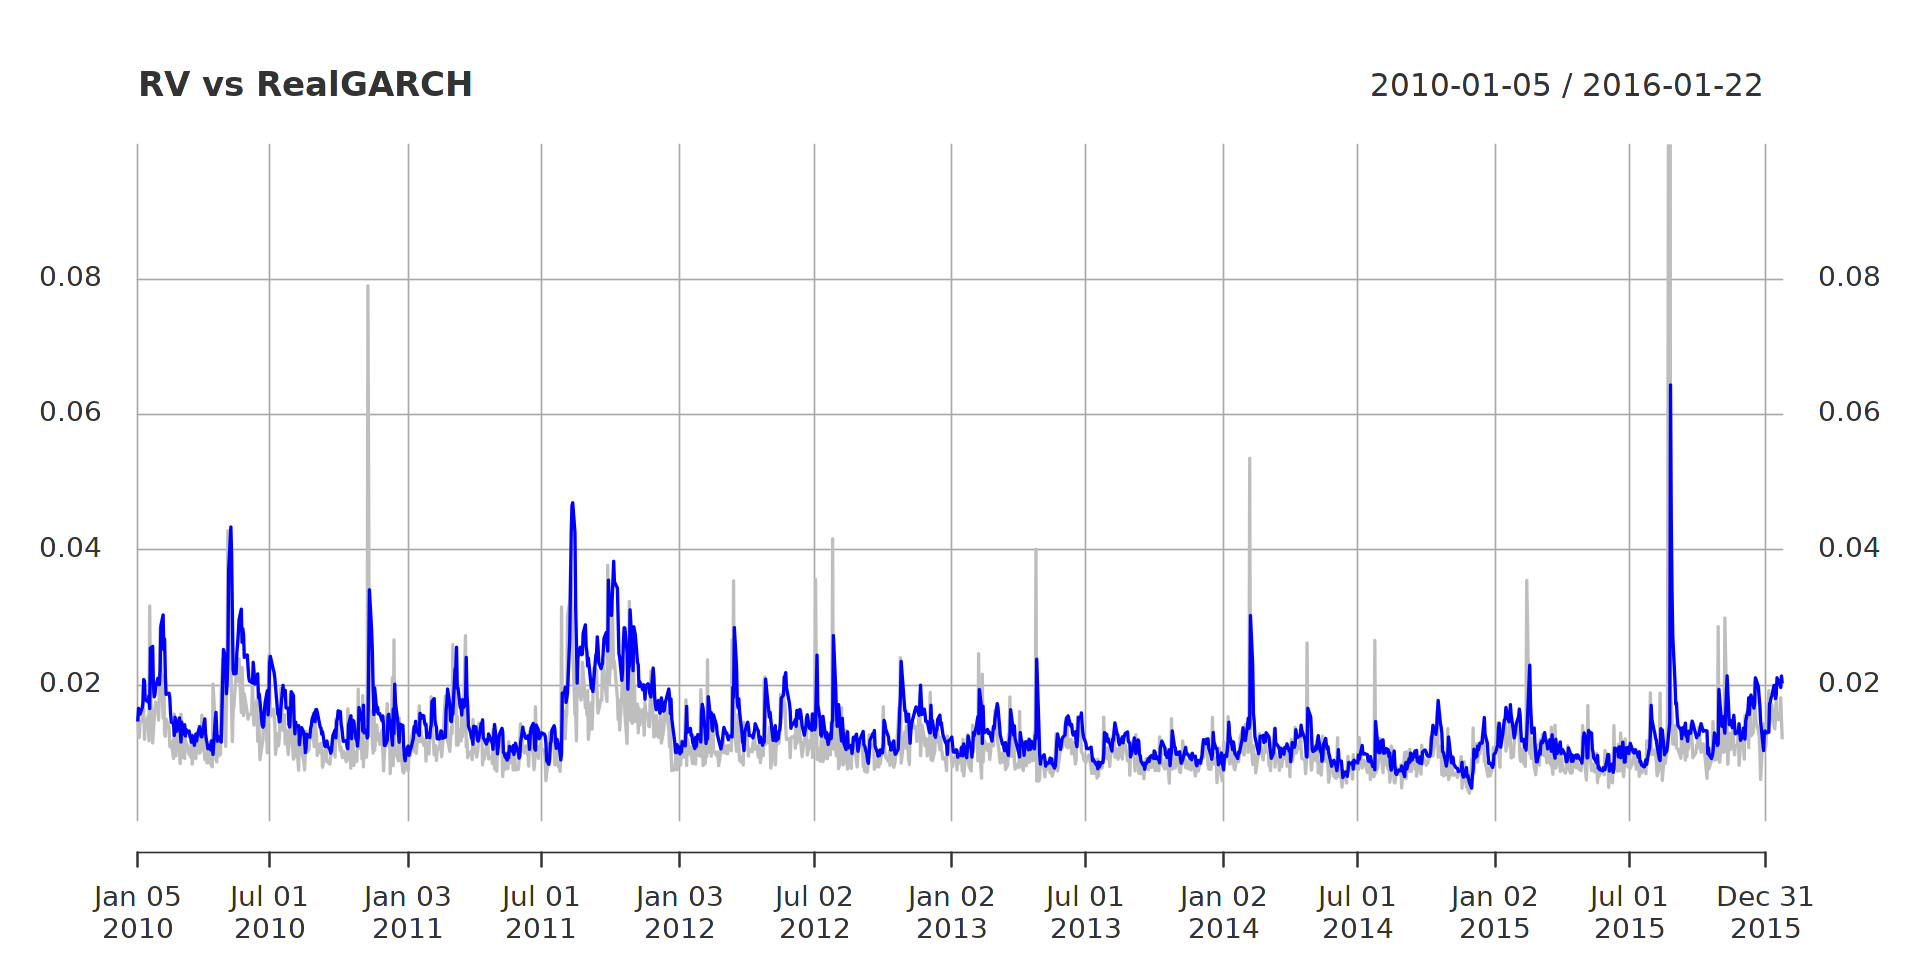

In [ ]:
realgarchspec <- ugarchspec(
    variance.model = list(model = "realGARCH", garchOrder = c(1, 1)),
    mean.model = list(armaOrder = c(0, 0), include.mean = TRUE)
)
real_garch <- ugarchfit(
  realgarchspec,
  aiz$ret,
  # "hybrid" did not converge
  solver = "gosolnp",
  realizedVol = aiz$RV
)

real_garch

real_garch_fit <- xts(real_garch@fit$sigma, order.by = index(aiz$RV))

plot(
  merge(real_garch_fit, aiz$RV),
  main = "RV vs RealGARCH",
  col = c("blue", "gray"),
  lwd = 2,
  legend.loc = "top",
  cex = 1,
  ylim = c(0, 0.1)
)

When analyzing the results of Realized GARCH, we focus on the coefficients of $\alpha_1$ and $\beta_1$ as they represent the impact of the log of past $x_t$ and the log of past estimated volatility on the current estimate of the log of current $x_t$, respectively. We observe that $\alpha_1$ is remarkably high, almost reaching 1.0, and it is also statistically significant. Additionally, the coefficient of $\beta_1$ is both economically and statistically significant. This suggests that although the log volatility estimate is strongly influenced by the log of past $x_t$, its responsiveness may be dampened by the relatively high coefficient of the log of past volatility.

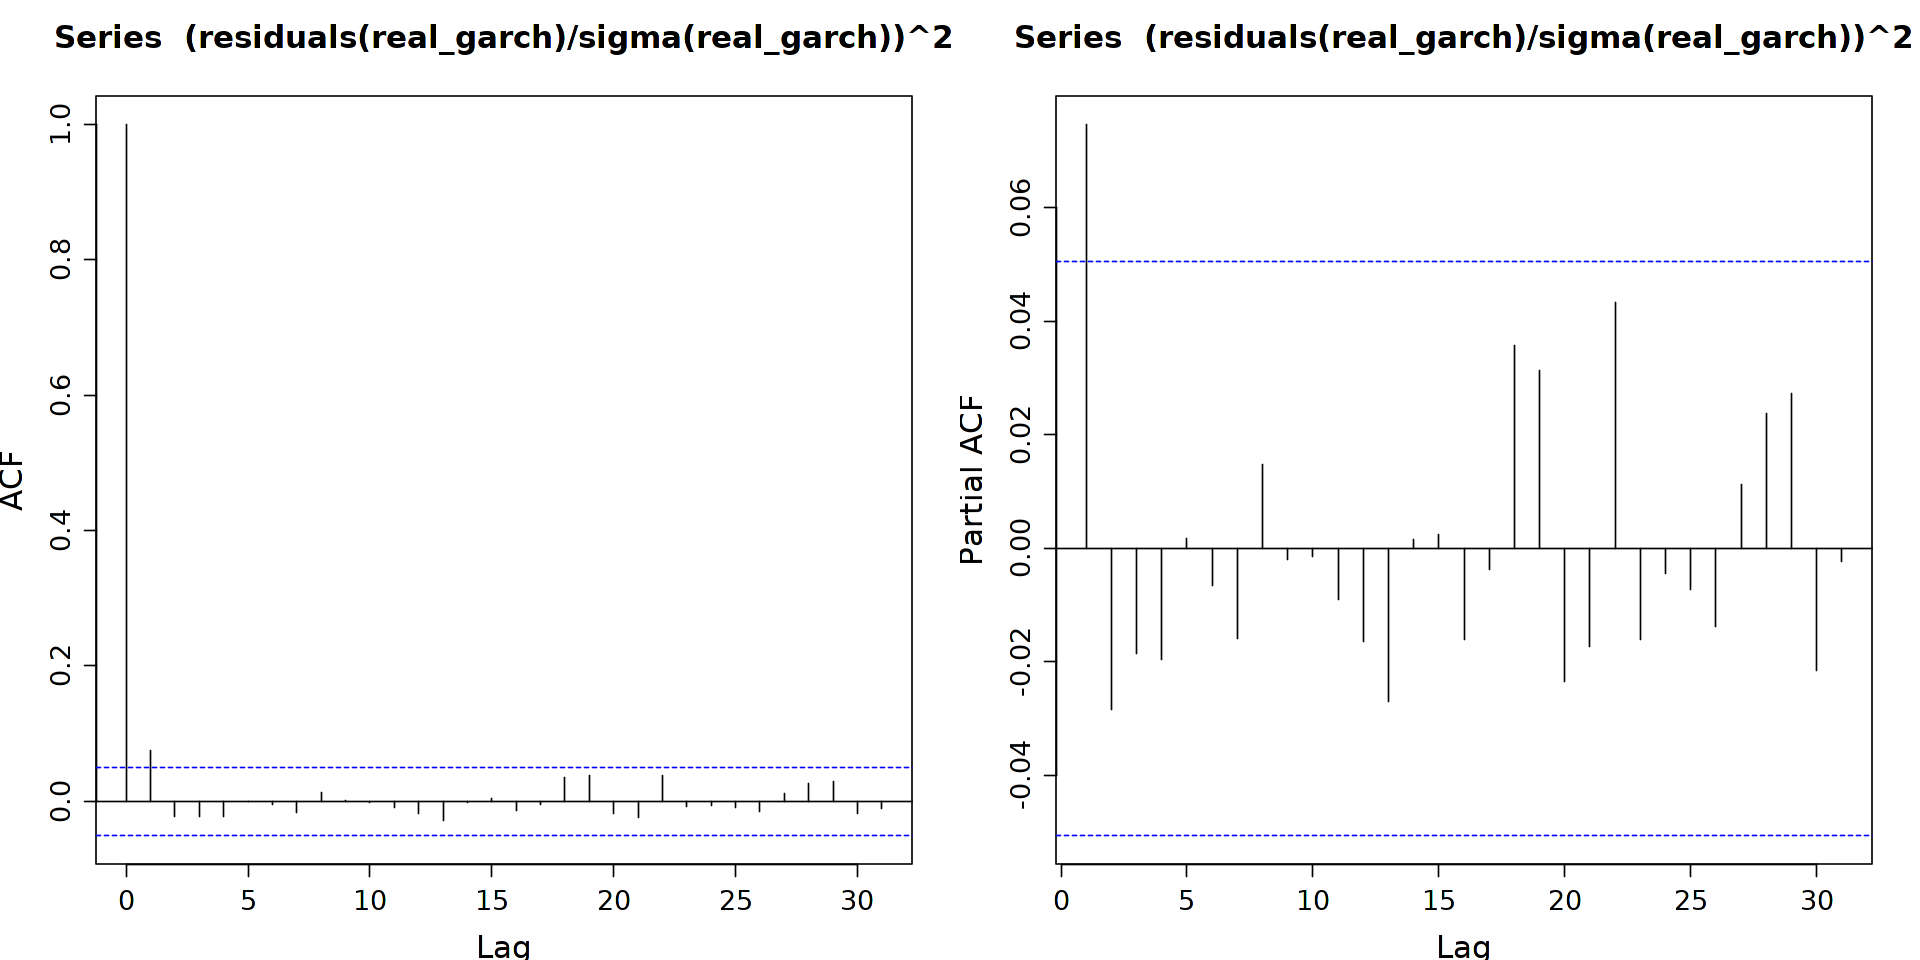

In [ ]:
par(mfrow = c(1, 2), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf((residuals(real_garch) / sigma(real_garch))^2)
pacf((residuals(real_garch) / sigma(real_garch))^2)

The ACF and PACF plots of the standardized squared residuals in the model exhibit a similar pattern to those observed in the case of HAR. This suggests that there is minimal remaining dependence in the residuals. Moreover, this argument is reinforced by the non-rejection of the null hypothesis in the Ljung-Box test conducted on the standardized squared residuals at various significance levels. However, it is important to note that the null hypothesis of the Ljung-Box test on the standardized residuals was rejected for certain lag specifications.

### ARMA-GARCH

The ARMA-GARCH model will aid to capture both the autoregressive and moving average components of our data, as well as the volatility clustering and time-varying volatility patterns. Mathematically, the ARMA-GARCH can be represented as follows:

$$ r_t = u_t,\ \text{where}\ u_t \sim N(0, \sigma^2_t) $$
$$ \sigma^2_t = \alpha_0 + \alpha_1 u_{t-1}^2 + \beta_1 \sigma^2_{t-1} \ \ \ \ \text{for} \ t=1,2,...,T $$

Firstly, we will determine the appropriate order for the mean equation in the ARMA model. To do this, we will consider information from both the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the returns. Additionally, we will use an automated algorithm that systematically explores different specifications and selects the best one based on information criteria. In this case, we will primarily focus on the Bayesian information criterion (BIC), which is known for its stringent criteria. To ensure a thorough search, we will set the approximation and stepwise arguments to false, allowing the algorithm to explore a wider range of specifications.

Series: aiz$ret 
ARIMA(0,0,0) with zero mean 

sigma^2 = 0.0002144:  log likelihood = 4207.39
AIC=-8412.78   AICc=-8412.78   BIC=-8407.47

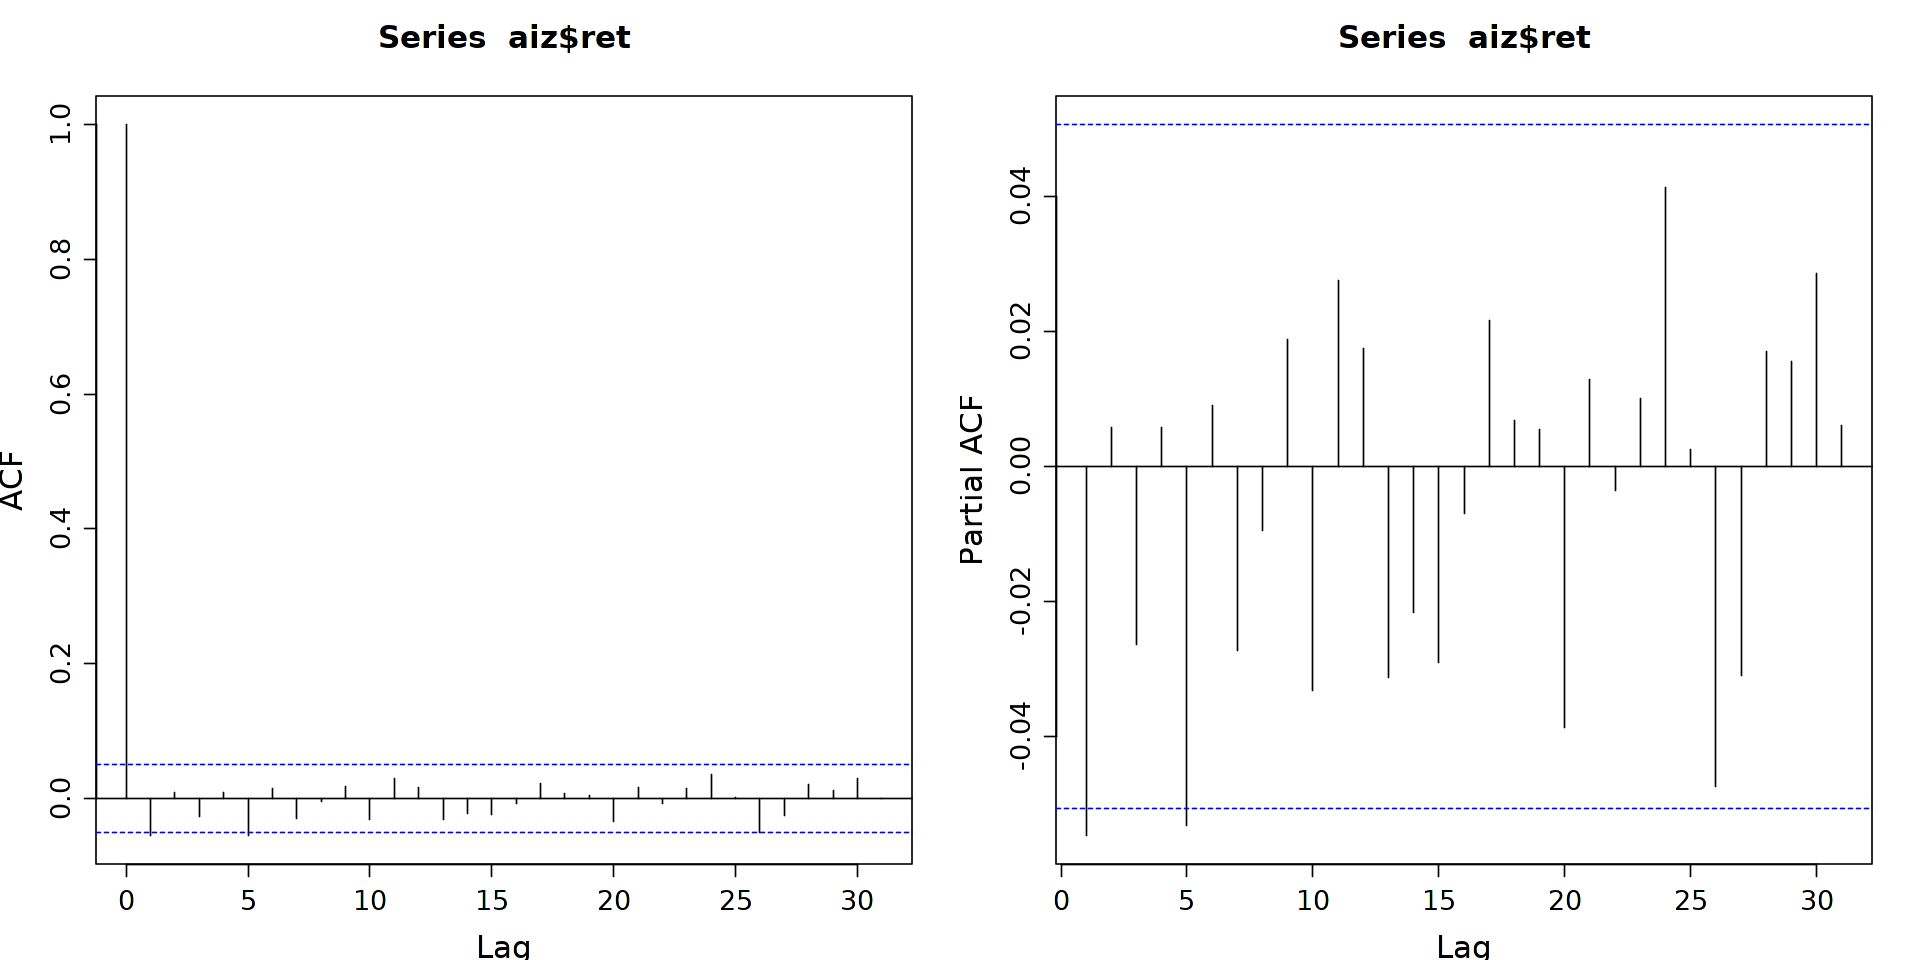

In [ ]:
auto.arima(aiz$ret, ic = "bic", stepwise = F, approximation = F)
par(mfrow = c(1, 2), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf(aiz$ret)
pacf(aiz$ret)
par(mfrow = c(1, 1))

Although we observe some statistically significant spikes in both the autocorrelation function (ACF) and partial autocorrelation function (PACF) at certain lags (e.g., lag 1), we are not convinced that these warrant the inclusion of lagged terms in the mean equation. This notion is also supported by the output of the auto.arima() function, even when excluding the constant term. In addition, it is common in empirical literature to use a GARCH(1,1) specification for modeling the variance. Therefore, we will proceed with modeling the variance using a GARCH(1,1) model and assess whether it provides a satisfactory goodness of fit.


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000015    0.000001  11.5961        0
alpha1  0.115531    0.012561   9.1974        0
beta1   0.819195    0.017335  47.2565        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000015    0.000003   5.6522        0
alpha1  0.115531    0.018503   6.2438        0
beta1   0.819195    0.026543  30.8630        0

LogLikelihood : 4273.32 

Information Criteria
------------------------------------
                    
Akaike       -5.6938
Bayes        -5.6831
Shibata      -5.6938
Hannan-Quinn -5.6898

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
            

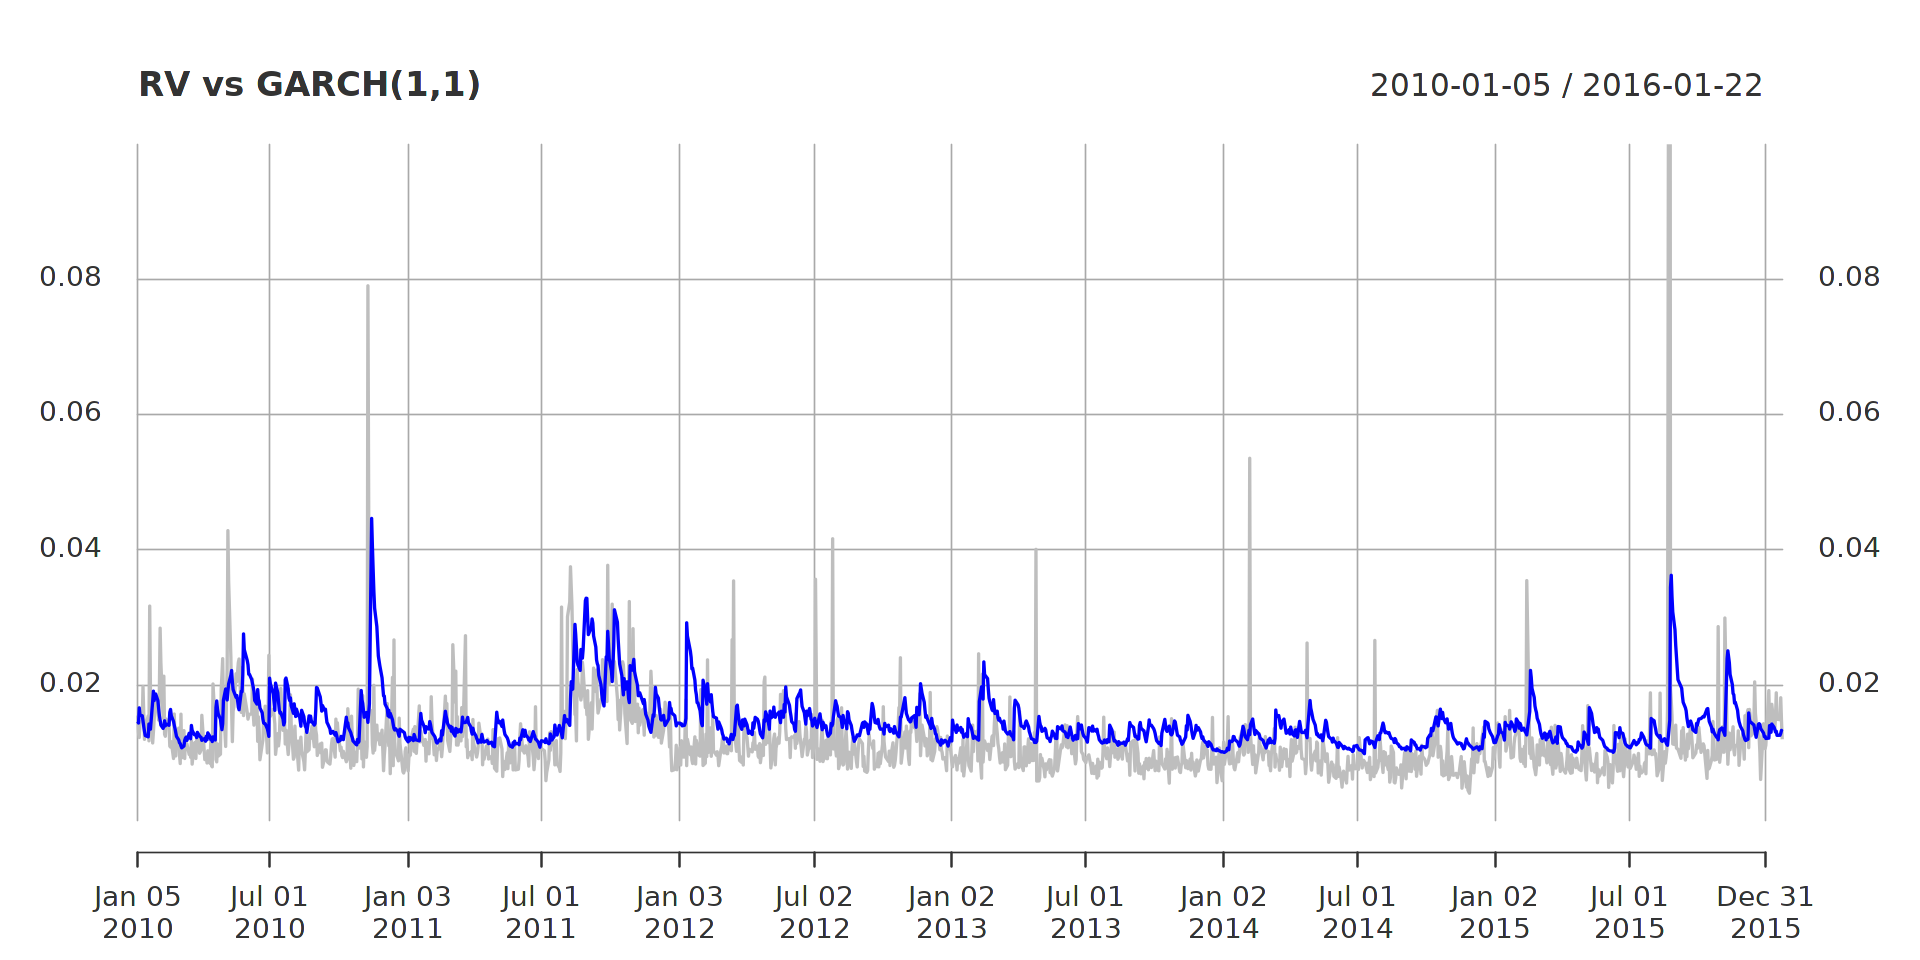

In [ ]:
armagarchspec <- ugarchspec(
    variance.model = list(
        garchOrder = c(1, 1)
    ),
    mean.model = list(
        armaOrder = c(0, 0),
        include.mean = F
    )
)

armagarch <- ugarchfit(armagarchspec, aiz$ret)
armagarch

armagarch_fit <- xts(armagarch@fit$sigma, order.by = index(aiz$RV))

plot(
  merge(armagarch_fit, aiz$RV),
  main = "RV vs GARCH(1,1)",
  col = c("blue", "gray"),
  lwd = 2,
  legend.loc = "top",
  cex = 1,
  ylim = c(0, 0.1)
)

Upon examining the results, it appears that the process is nearly unit-root, as the sum of both alpha and beta coefficients approaches 1. Considering an IGARCH specification may be worthwhile in this case. Analyzing the results further, we observe that the coefficient for $\beta_1$ is 0.819195 and statistically significant. This suggests a substantial presence of volatility clustering and a longer memory effect on volatility. On the other hand, the coefficient for $\alpha_1$ is relatively low at 0.115531, but it is still statistically significant. This indicates that recent movements have a less significant impact on volatility compared to past volatility.

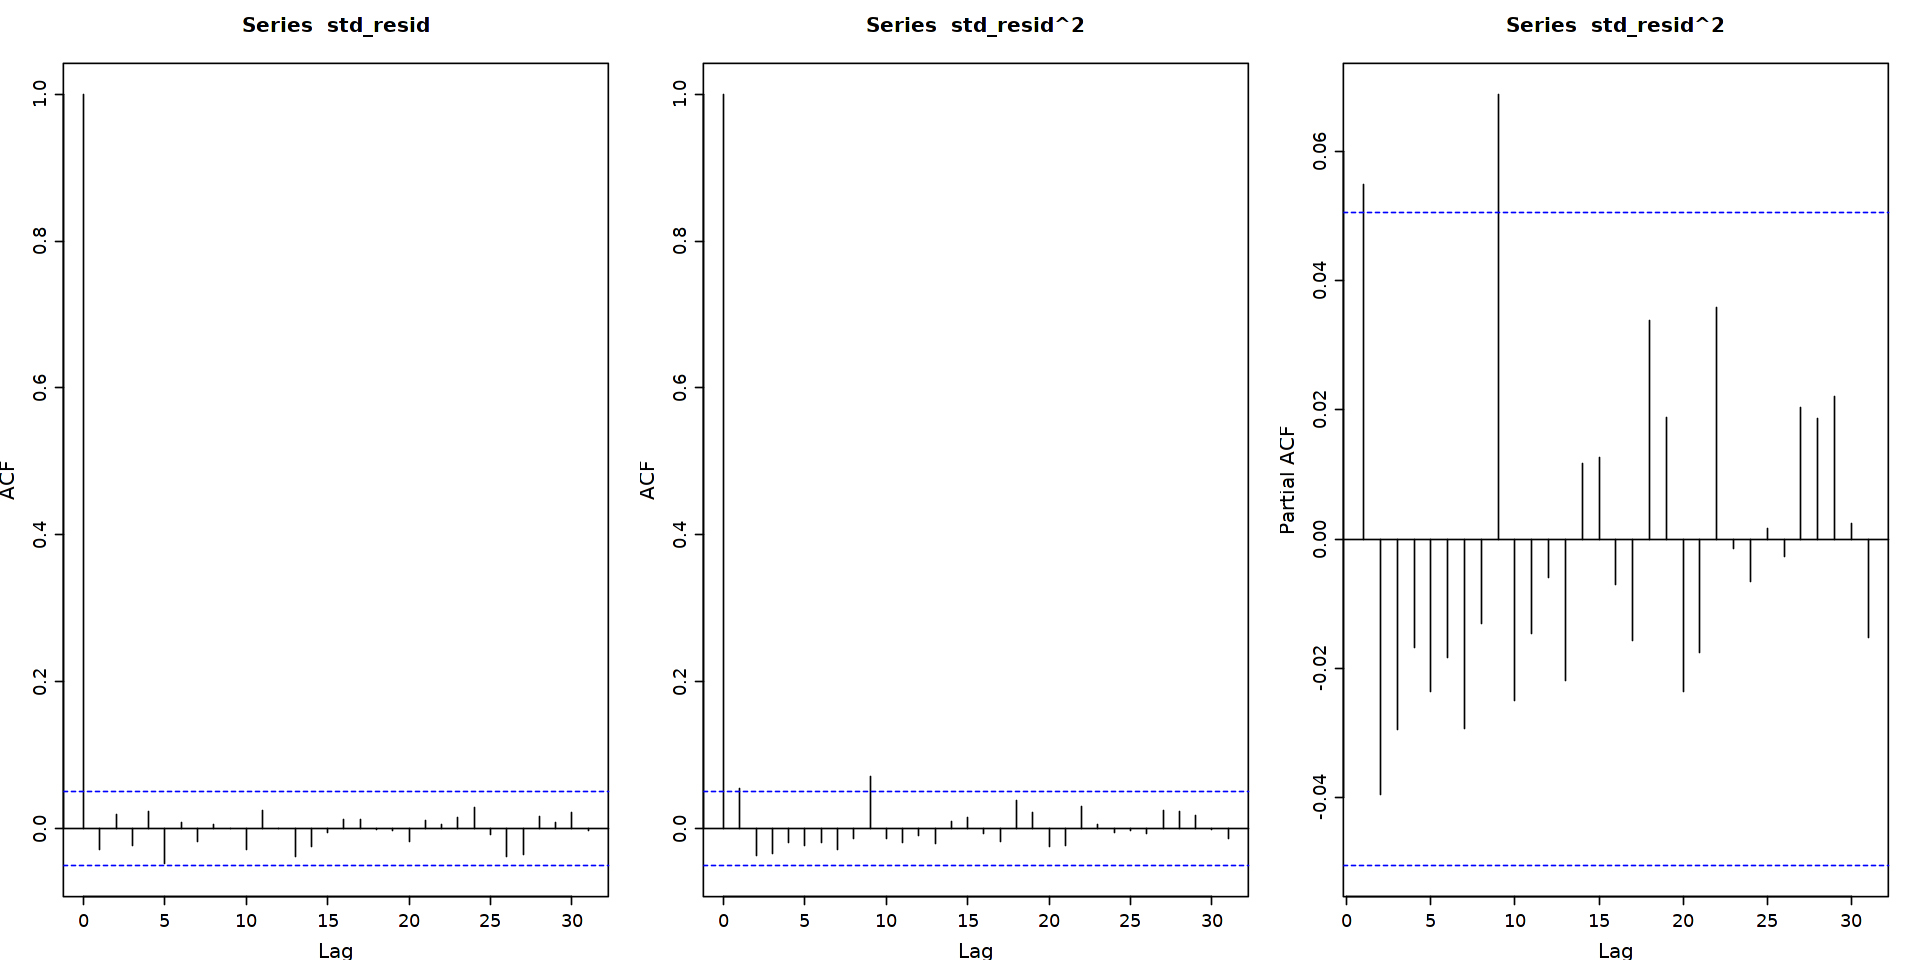

In [ ]:
par(mfrow = c(1, 3), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
std_resid <- residuals(armagarch) / sigma(armagarch)
acf(std_resid)
acf(std_resid^2)
pacf(std_resid^2)
par(mfrow = c(1, 1))

Upon examining the ACF and PACF plots of the standardized residuals, we can observe that the inclusion of the $GARCH(1,1)$ model effectively eliminates most of the dependence in the residuals. This finding is further supported by the results of the Ljung-Box tests, as indicated in the extensive text output.

### Comparison

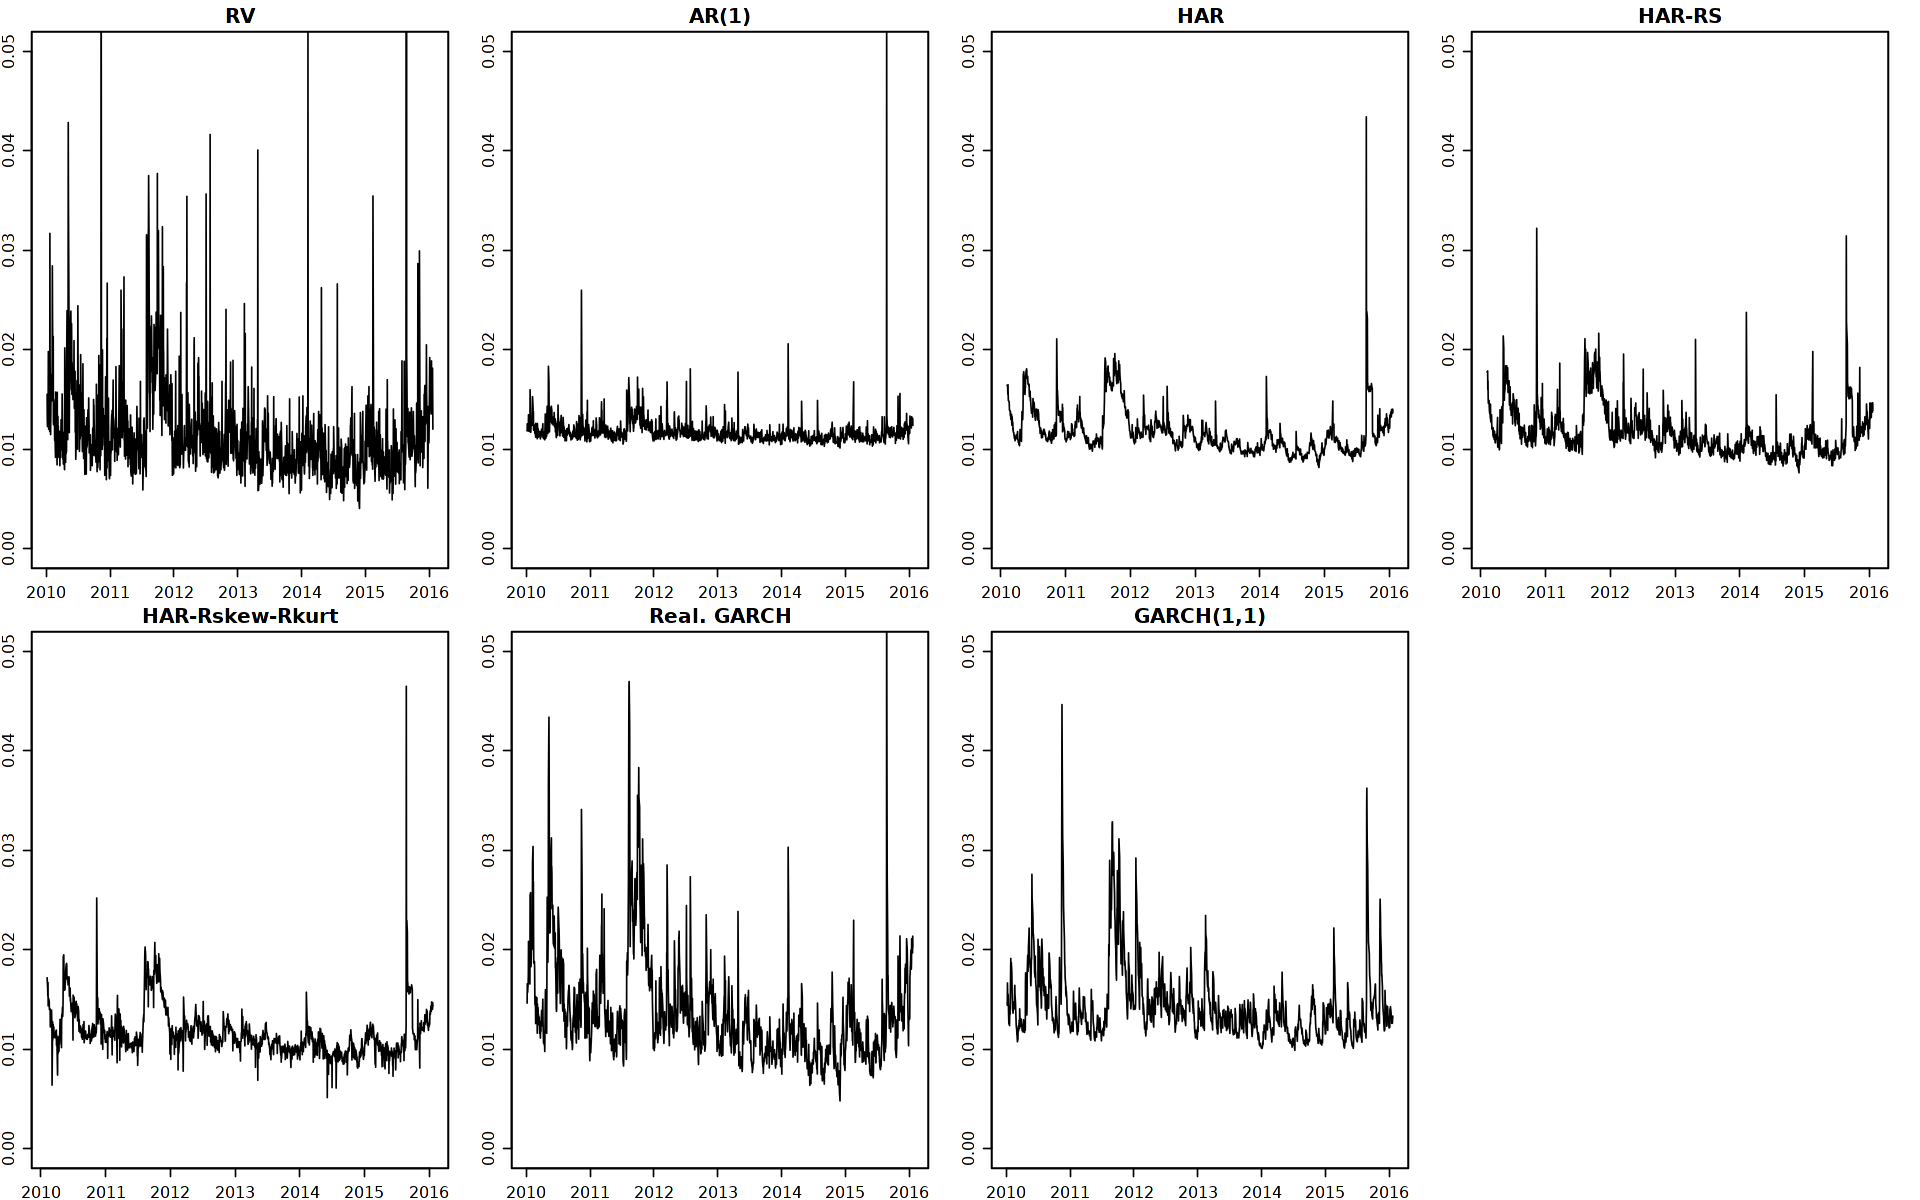

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)
par(mfrow = c(2, 4), mar = c(2, 2, 2, 2), cex.axis = 1.15, cex.main = 1.5, cex.lab = 1.2)
plot.zoo(aiz$RV, ylim = c(0, 0.05), main = "RV")
plot.zoo(ar1_fit, ylim = c(0, 0.05), main = "AR(1)")
plot.zoo(har_fit, ylim = c(0, 0.05), main = "HAR")
plot.zoo(har_rs_fit, ylim = c(0, 0.05), main = "HAR-RS")
plot.zoo(har_skew_kurt_fit, ylim = c(0, 0.05), main = "HAR-Rskew-Rkurt")
plot.zoo(real_garch_fit, ylim = c(0, 0.05), main = "Real. GARCH")
plot.zoo(armagarch_fit, ylim = c(0, 0.05), main = "GARCH(1,1)")

The figures provided do not provide significant insights. However, it can be noted that none of the fitted values exhibit the same level of variability as RV. The AR or HAR models may be considered somewhat competitive in this aspect. To gain a better understanding of the models' performance in-sample, we will calculate the R-squared (squared correlation of fitted values and RV) and the root mean square error (RMSE) on the in-sample data.

In [ ]:
rsq <- function(a, b) {
  vec <- na.omit(merge(a, b))
  r2 <- as.numeric(cor(vec[, 1], vec[, 2])^2)
  round(r2, 4)
}

rmses_in_sample <- c(
  rmse(aiz$RV, ar1_fit),
  rmse(aiz$RV[23:TT], har_fit),
  rmse(aiz$RV[23:TT], har_rs_fit),
  rmse(aiz$RV[23:TT], har_skew_kurt_fit),
  rmse(aiz$RV, real_garch_fit),
  rmse(aiz$RV, armagarch_fit)
)

rsquareds <- c(
  rsq(aiz$RV, ar1_fit),
  rsq(aiz$RV[23:TT], har_fit),
  rsq(aiz$RV[23:TT], har_rs_fit),
  rsq(aiz$RV[23:TT], har_skew_kurt_fit),
  rsq(aiz$RV, real_garch_fit),
  rsq(aiz$RV, armagarch_fit)
)

df <- as.data.frame(cbind(rmses_in_sample, rsquareds))
colnames(df) <- c("In-sample RMSE", "R-squared")
rownames(df) <- c("AR(1)", "HAR", "HAR-RS", "HAR-Rskew-Rkurt", "Real. GARCH", "GARCH(1,1)")
df

,In-sample RMSE,R-squared
,<dbl>,<dbl>
AR(1),0.007478906,0.0448
HAR,0.007312122,0.0896
HAR-RS,0.007265661,0.1012
HAR-Rskew-Rkurt,0.007267377,0.1008
Real. GARCH,0.007927402,0.1166
"GARCH(1,1)",0.008207511,0.0455


In the table above, we are aiming for low values of RMSE and high values of R-squared. Based on these criteria, we can observe that the HAR-family models perform the best in both aspects. They have an RMSE of around 0.0073 and an R-squared measure exceeding 10%. With regards to the R-squared value only the real GARCH outperforms the HAR family models with over 11%, however it has the 2nd highest RMSE value out of all models. On the other hand, the $GARCH(1,1)$ model appears to be objectively the worst, as it has the highest RMSE and the lowest r-squared value. Such findings align with expectations considering the nature of the outcome variable. 

## Forecasts

To compare the out-of-sample forecasting performance of the models, we will use recursive and rolling windows with a length of 750 for each volatility model. For each model, we plot and compare the forecast performance of the models with the realized volatility of the asset.

### AR(1)-RV

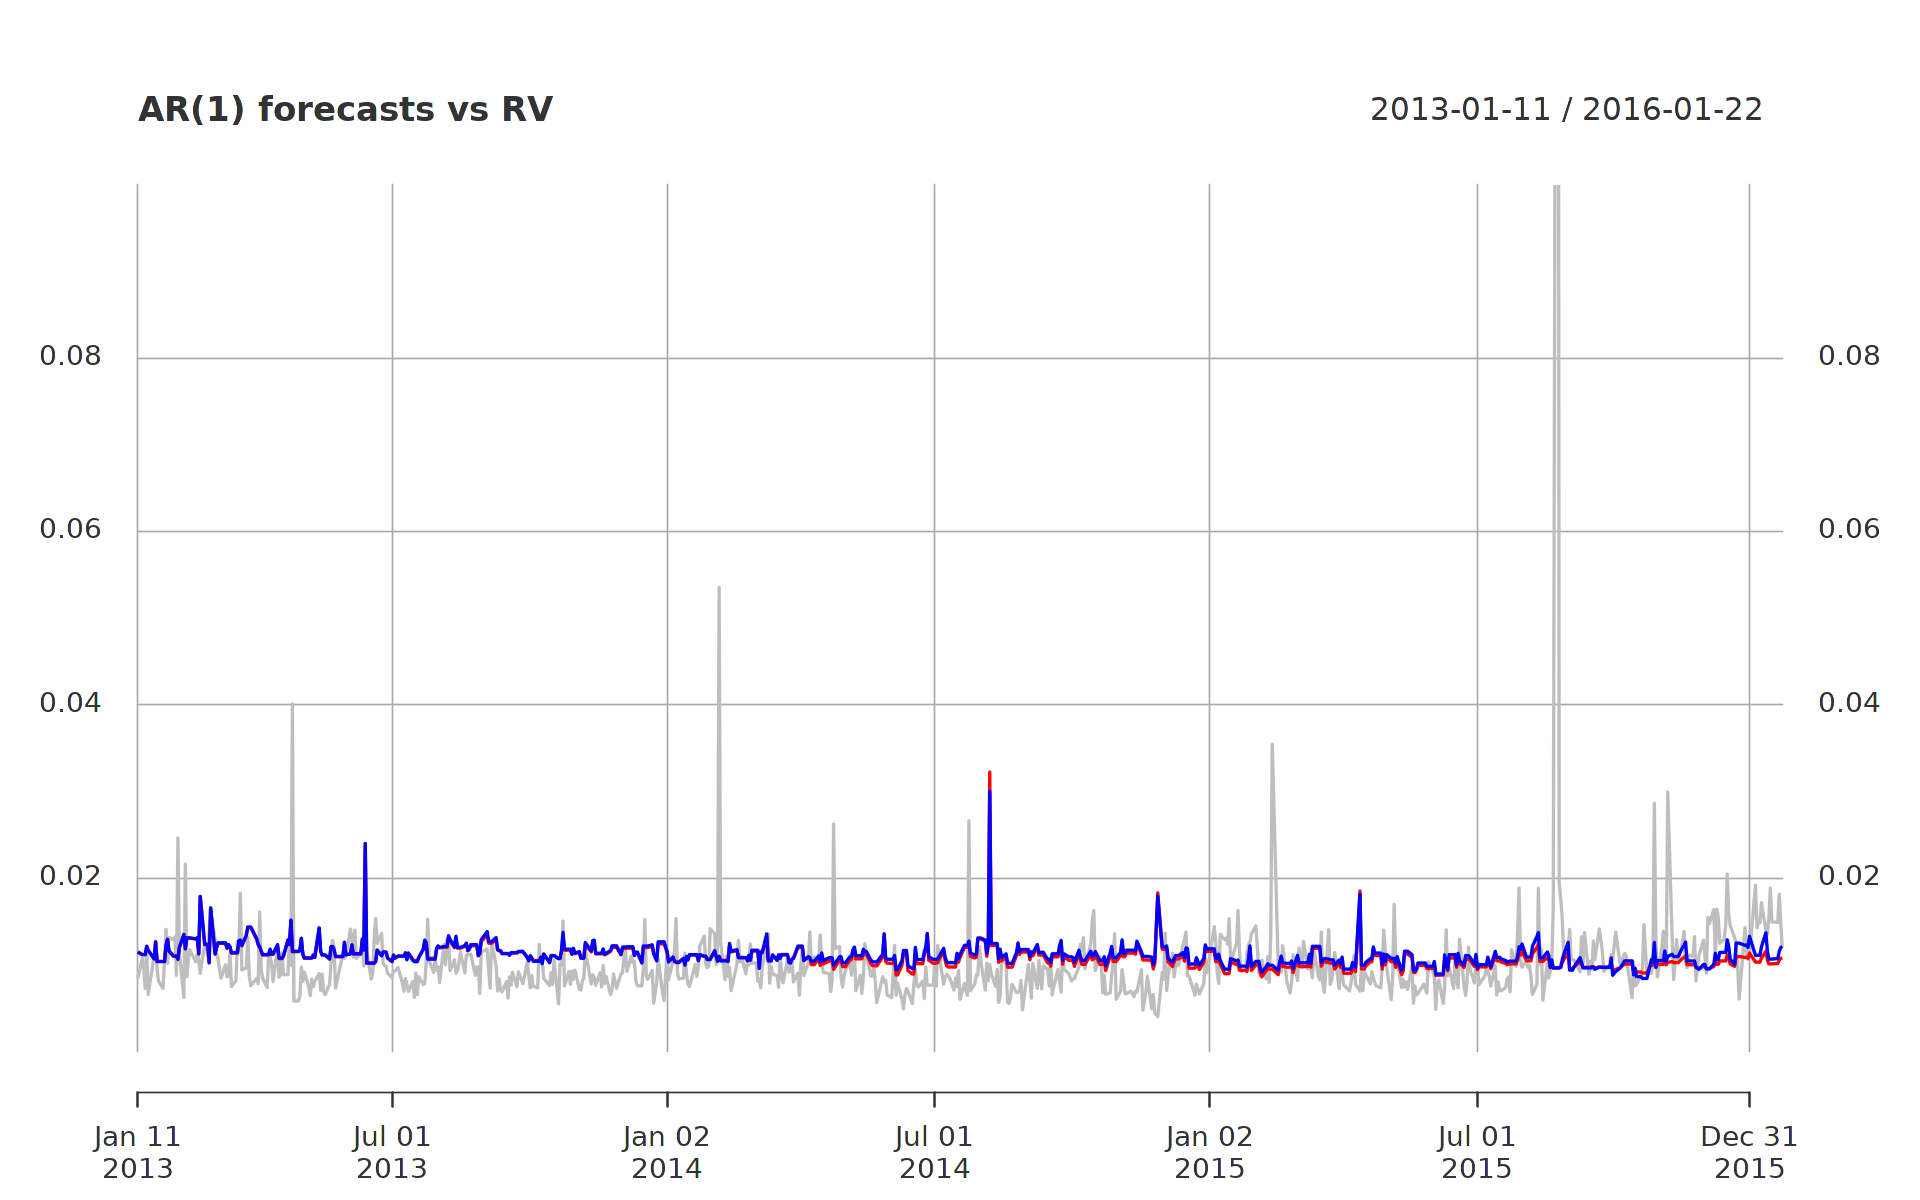

In [ ]:
start_date <- index(aiz$RV)[1]
mid_date <- index(aiz$RV)[750]
end_date <- index(aiz$RV)[length(aiz$RV)]

# Out of sample set
testing_ar <- window(aiz$RV, start = mid_date + 1, end = end_date)

forecasts_rec_ar <- rep(NA, length(testing_ar))
forecasts_roll_ar <- rep(NA, length(testing_ar))

# Recursive window
for (i in 0:(length(testing_ar) - 1)) {
  #Dataset used for testing and in-sample testing
  testing_dataset <- window(aiz$RV, start = start_date, end = mid_date + i)
  mod <- Arima(testing_dataset, order = c(1, 0, 0))

  forecasts_rec_ar[i + 1] <- predict(mod, n.ahead = 1)$pred[1]
}

# Rolling window
for (i in 0:(length(testing_ar) - 1)) {
  testing_dataset <- window(aiz$RV, start = start_date + i, end = mid_date + i)
  mod <- Arima(testing_dataset, order = c(1, 0, 0))

  forecasts_roll_ar[i + 1] <- predict(mod, n.ahead = 1)$pred[1]
}

dat_ar <- merge(
  xts(forecasts_rec_ar, order.by = index(aiz$RV[751:1500])),
  xts(forecasts_roll_ar, order.by = index(aiz$RV[751:1500])),
  aiz$RV[751:1500]
)

colnames(dat_ar) <- c("Recursive", "Rolling", "RV")

plot(
  dat_ar,
  main = "AR(1) forecasts vs RV",
  col = c("blue", "red", "gray"),
  lwd = 2,
  legend.loc = "topleft",
  cex = 1,
  ylim = c(0, 0.1)
)

The AR(1) model looks to be underfitted and shows relatively weak in-sample performance, likewise, the out-of-sample performance for both the rolling and recursive windows looks to be relatively inaccurate as well.  

### HAR, HAR-RS and HAR-Rskew-Rkurt

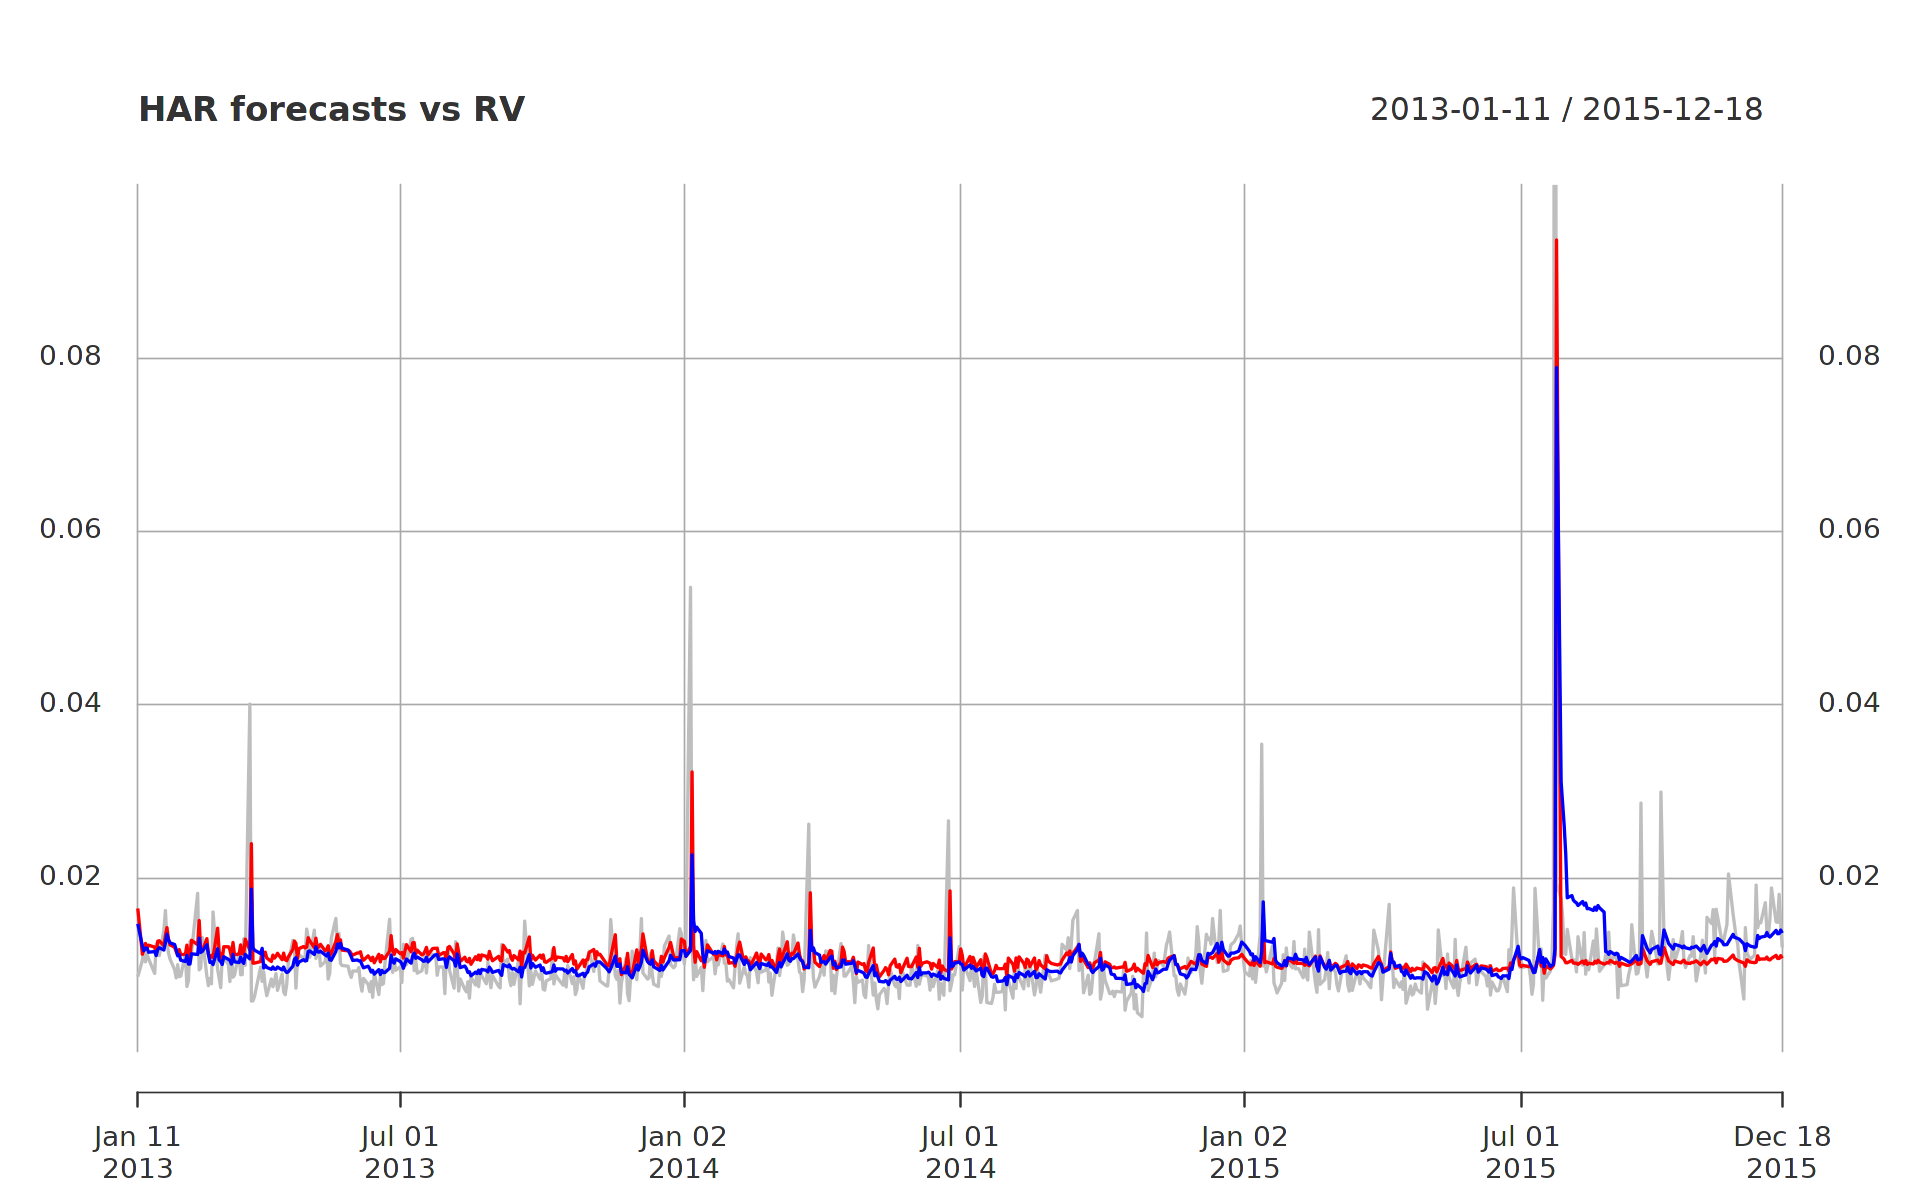

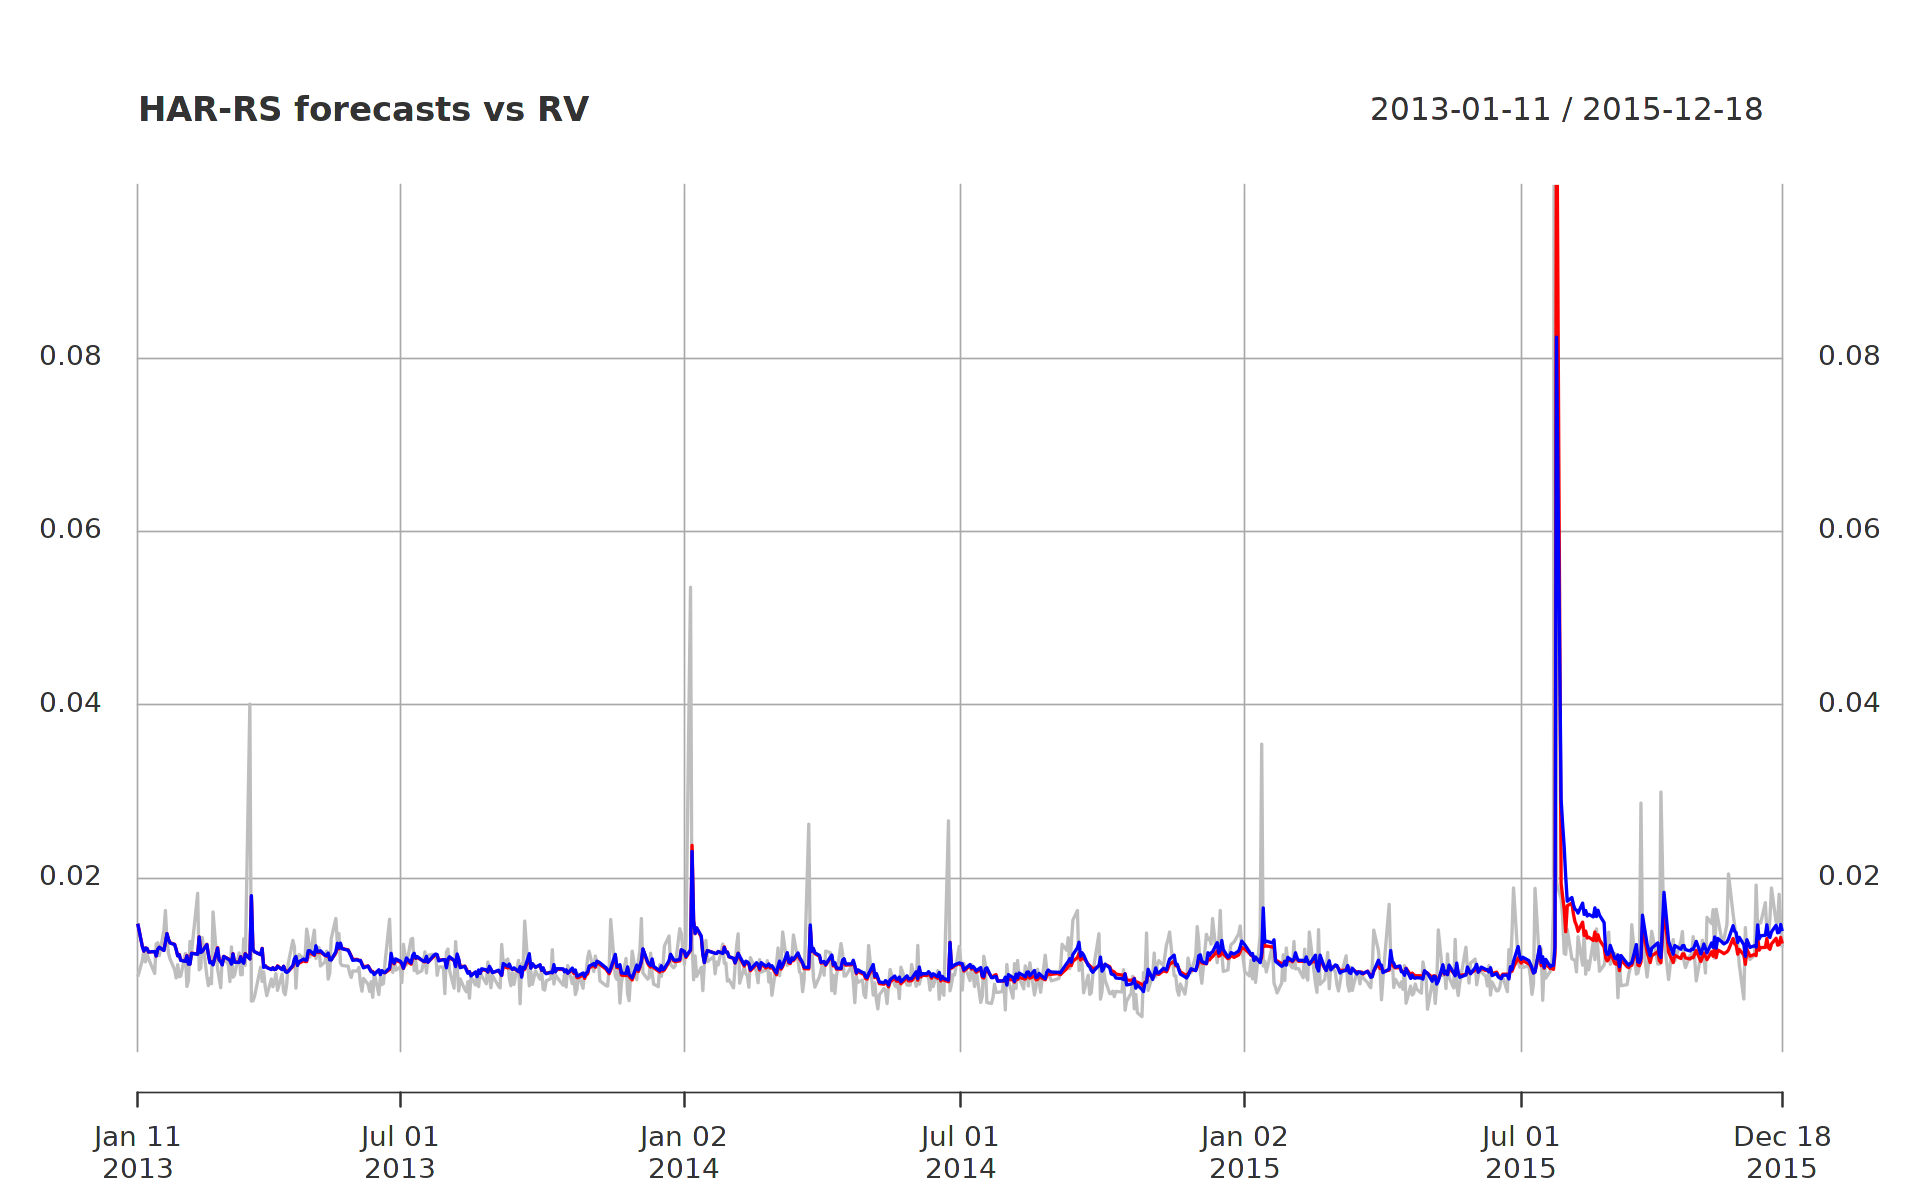

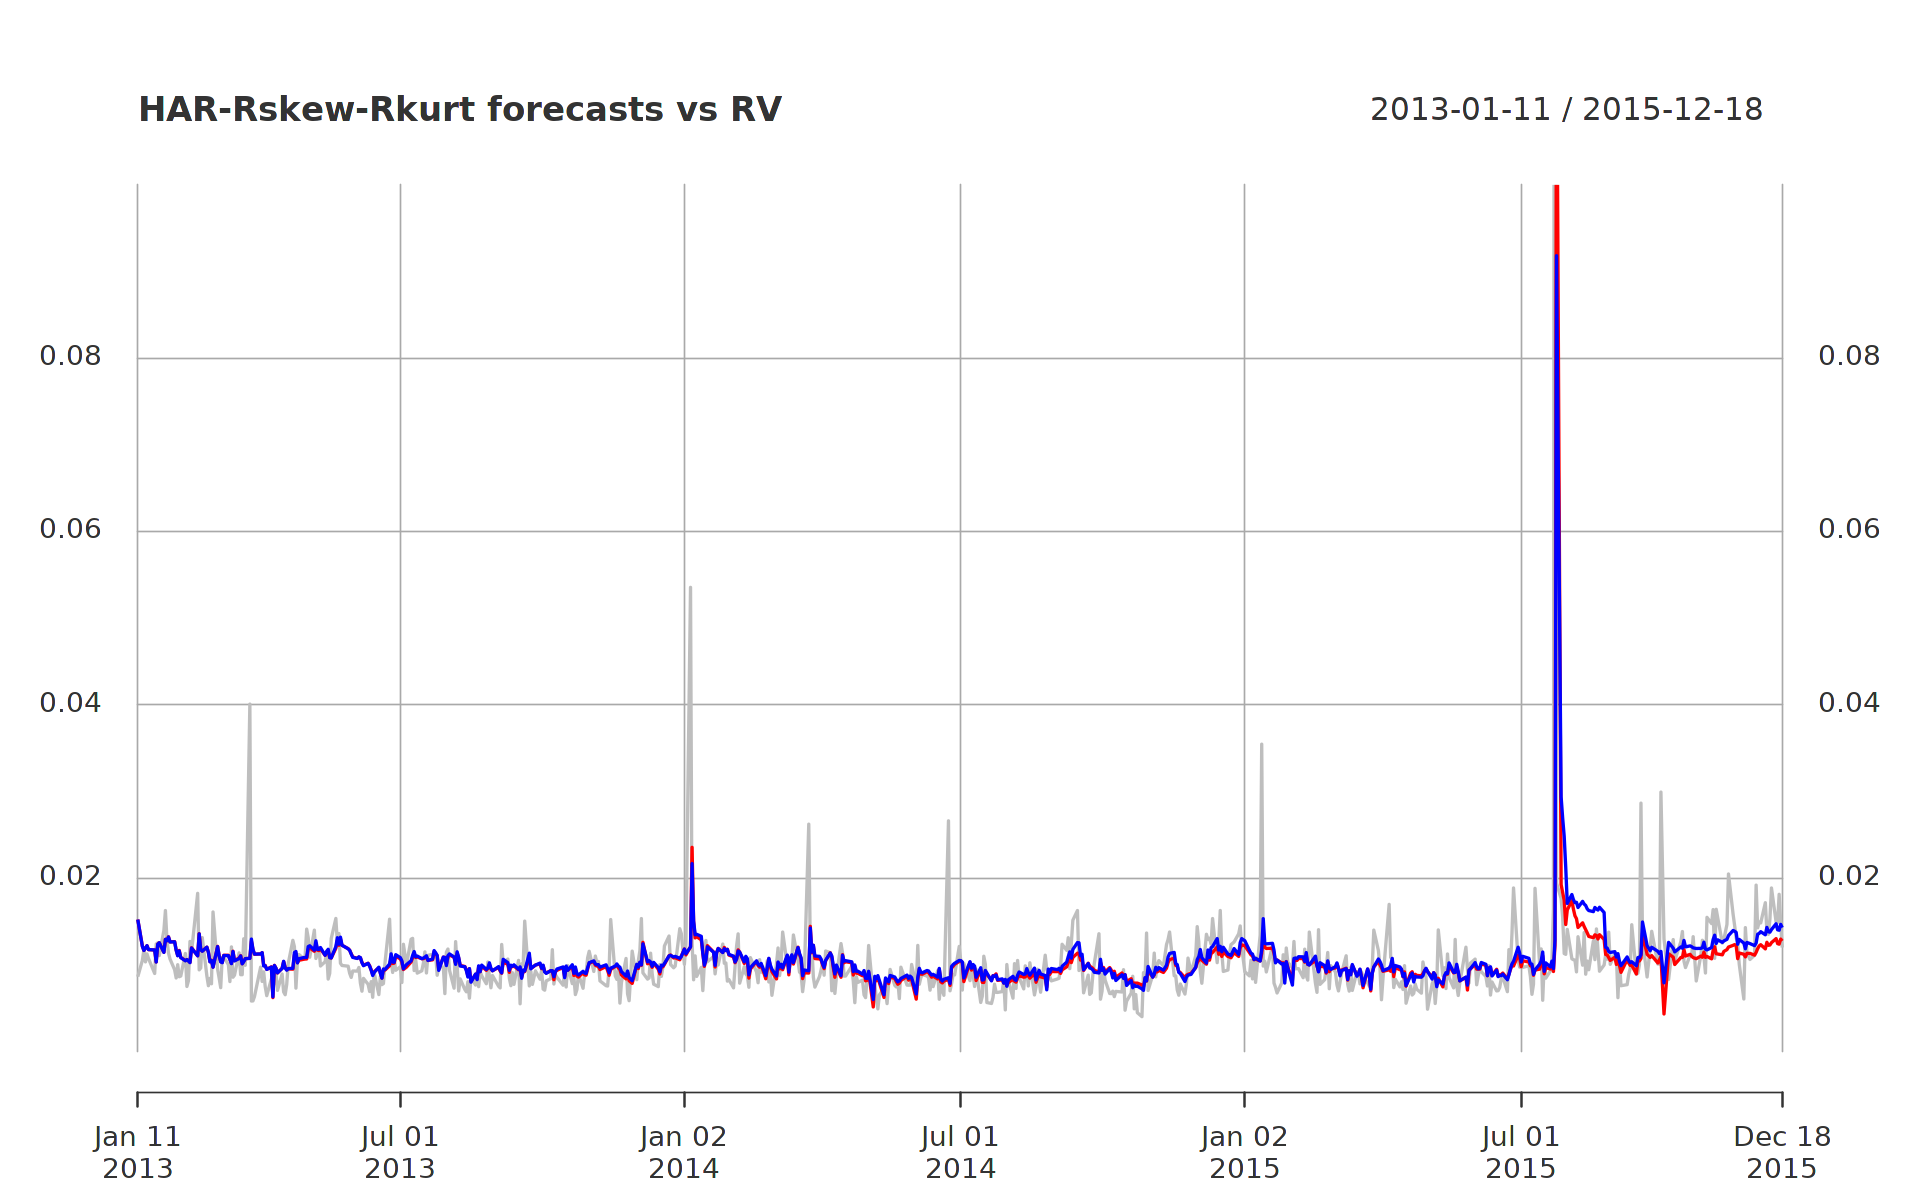

In [ ]:
start_pos <- 1
mid_pos <- 750
end_pos <- nrow(har_data_ts)

testing_har <- har_data_ts[(mid_pos + 1):end_pos, ] %>% ts()

forecasts_rec_har <- rep(NA, nrow(testing_har))
forecasts_roll_har <- rep(NA, nrow(testing_har))
forecasts_rec_har_rs <- rep(NA, nrow(testing_har))
forecasts_roll_har_rs <- rep(NA, nrow(testing_har))
forecasts_rec_har_sk <- rep(NA, nrow(testing_har))
forecasts_roll_har_sk <- rep(NA, nrow(testing_har))

# Recursive window
for (i in 0:(nrow(testing_har) - 1)) {
  test_dataset <- har_data_ts[start_pos:(mid_pos + i), ] %>% ts()
  newdat <- har_data[mid_pos + i + 1, -1]
  mod_har <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22, data = test_dataset)
  mod_har_rs <- tslm(rv_t0 ~ rvn + rvp + rv5 + rv22, data = test_dataset)
  mod_har_sk <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = test_dataset)

  forecasts_rec_har[i + 1] <- forecast(mod_har, newdata = newdat)$mean[1]
  forecasts_rec_har_rs[i + 1] <- forecast(mod_har_rs, newdata = newdat)$mean[1]
  forecasts_rec_har_sk[i + 1] <- forecast(mod_har_sk, newdata = newdat)$mean[1]
}

# Rolling window
for (i in 0:(nrow(testing_har) - 1)) {
  temp_dataset <- har_data_ts[(start_pos + i):(mid_pos + i), ] %>% ts()
  newdat <- har_data[mid_pos + i + 1, -1]
  mod_har <- tslm(rv_t0 ~ rv_t1, data = temp_dataset)
  mod_har_rs <- tslm(rv_t0 ~ rvn + rvp + rv5 + rv22, data = temp_dataset)
  mod_har_sk <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = temp_dataset)

  forecasts_roll_har[i + 1] <- forecast(mod_har, newdata = newdat)$mean[1]
  forecasts_roll_har_rs[i + 1] <- forecast(mod_har_rs, newdata = newdat)$mean[1]
  forecasts_roll_har_sk[i + 1] <- forecast(mod_har_sk, newdata = newdat)$mean[1]
}

dat_har <- merge(
  xts(forecasts_rec_har, order.by = index(aiz$RV[751:(1500 - 22)])),
  xts(forecasts_roll_har, order.by = index(aiz$RV[751:(1500 - 22)])),
  xts(testing_har[, "rv_t0"], order.by = index(aiz$RV[751:(1500 - 22)]))
)
dat_har_rs <- merge(
  xts(forecasts_rec_har_rs, order.by = index(aiz$RV[751:(1500 - 22)])),
  xts(forecasts_roll_har_rs, order.by = index(aiz$RV[751:(1500 - 22)])),
  xts(testing_har[, "rv_t0"], order.by = index(aiz$RV[751:(1500 - 22)]))
)
dat_har_sk <- merge(
  xts(forecasts_rec_har_sk, order.by = index(aiz$RV[751:(1500 - 22)])),
  xts(forecasts_roll_har_sk, order.by = index(aiz$RV[751:(1500 - 22)])),
  xts(testing_har[, "rv_t0"], order.by = index(aiz$RV[751:(1500 - 22)]))
)

colnames(dat_har) <- c("Recursive", "Rolling", "RV")
colnames(dat_har_rs) <- c("Recursive", "Rolling", "RV")
colnames(dat_har_sk) <- c("Recursive", "Rolling", "RV")

plot(
  dat_har,
  main = "HAR forecasts vs RV",
  col = c("blue", "red", "gray"),
  lwd = 2,
  legend.loc = "topleft",
  cex = 1,
  ylim = c(0, 0.1)
)
plot(
  dat_har_rs,
  main = "HAR-RS forecasts vs RV",
  col = c("blue", "red", "gray"),
  lwd = 2,
  legend.loc = "topleft",
  cex = 1,
  ylim = c(0, 0.1)
)
plot(
  dat_har_sk,
  main = "HAR-Rskew-Rkurt forecasts vs RV",
  col = c("blue", "red", "gray"),
  lwd = 2,
  legend.loc = "topleft",
  cex = 1,
  ylim = c(0, 0.1)
)

Regarding the out-of-sample forecasting, all the HAR models look to be accurate in predicting and have seemingly good performance. The HAR models look to have the best performance out of all the models that were tested. 

### Realized GARCH and ARMA-GARCH

In [ ]:
f_rec_rg <- ugarchroll(
  realgarchspec,
  aiz$ret,
  n.ahead = 1,
  forecast.length = 750,
  #Increased refit period
  refit.every = 5,
  refit.window = "recursive",
  realizedVol = sqrt(aiz$RV),
  calculate.VaR = F,
  window.size = 750,
  parallel = T,
  parallel.control = list(pkg = "multicore", cores = 12),
  solver.control = list(rho = 1, delta = 1e-9, outer.iter = 100, tol = 1e-7),
  solver = "gosolnp"
)
f_rec_rg <- resume(f_rec_rg, solver = "nloptr")
f_rec_rg <- resume(f_rec_rg, solver = "hybrid")
f_rec_rg <- resume(f_rec_rg, solver = "gosolnp")
f_rec_rg <- resume(f_rec_rg,solver.control = list(rho = 1, delta = 1e-9, outer.iter = 100, tol = 1e-12), solver = "gosolnp")
f_rec_rg <- resume(f_rec_rg, solver = "solnp")
f_rec_rg <- resume(f_rec_rg, solver = "nlminb")

Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .realgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->warning: solver failer to converge.”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGA

In [ ]:
f_roll_rg <- ugarchroll(
  realgarchspec,
  aiz$ret,
  n.ahead = 1,
  forecast.length = 750,
  refit.every = 5,
  refit.window = "moving",
  realizedVol = sqrt(aiz$RV),
  calculate.VaR = F,
  window.size = 750,
  parallel = T,
  parallel.control = list(pkg = "multicore", cores = 12),
  solver.control = list(rho = 1, delta = 1e-9, outer.iter = 100, tol = 1e-7),
  solver = "gosolnp"
)
f_roll_rg <- resume(f_roll_rg, solver = "nloptr")
f_roll_rg <- resume(f_roll_rg, solver = "hybrid")
f_rec_rg <- resume(f_rec_rg,solver.control = list(rho = 1, delta = 1e-9, outer.iter = 100, tol = 1e-10), solver = "gosolnp")
f_roll_rg <- resume(f_roll_rg, solver = "gosolnp")
f_rec_rg <- resume(f_rec_rg,solver.control = list(rho = 1, delta = 1e-9, outer.iter = 100, tol = 1e-12), solver = "gosolnp")
f_rec_rg <- resume(f_rec_rg,solver.control = list(rho = 1, delta = 1e-8, outer.iter = 100, tol = 1e-7), solver = "gosolnp")
f_rec_rg <- resume(f_rec_rg,solver.control = list(rho = 1, delta = 1e-8, outer.iter = 100, tol = 1e-9), solver = "gosolnp")
f_roll_rg <- resume(f_roll_rg, solver = "solnp")
f_roll_rg <- resume(f_roll_rg, solver = "nlminb")

Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARCH", f = .realgarchLLH, T = T, :
“
rugarch-->warning: failed to invert hessian
”
Warning message in .makefitmodel(garchmodel = "realGARC

Some adjustments were made to the parameters of the solver algorithm and the refit period was set to 5 due to convergence issues. Further, as seen in the code block below, certain incongruous values were removed from the realized GARCH forecast results and were treated as outliers. As suggested by the rugarch documentation and other tangential resources, these incongruous results were likely due to the realized GARCH algorithm solver not being optimized to be resistant to outliers. 

In [ ]:
f_rec_ag <- ugarchroll(
  armagarchspec,
  aiz$ret,
  n.ahead = 1,
  forecast.length = 750,
  refit.every = 5,
  refit.window = "recursive",
  calculate.VaR = F,
  parallel = T,
  window.size = 750
)

f_roll_ag <- ugarchroll(
  armagarchspec,
  aiz$ret,
  n.ahead = 1,
  forecast.length = 750,
  refit.every = 5,
  refit.window = "moving",
  calculate.VaR = F,
  parallel = T,
  window.size = 750
)

#Remove outliers
out1 <- boxplot.stats(f_rec_rg@forecast$density$Sigma)$out
f_out1 <- f_rec_rg@forecast$density$Sigma
f_out1[f_out1 %in% out1] <- NA
out2 <- boxplot.stats(f_roll_rg@forecast$density$Sigma)$out
f_out2 <- f_roll_rg@forecast$density$Sigma
f_out2[f_out2 %in% out2] <- NA

fcsts_garch <- cbind(
  f_out1,
  f_out2,
  f_rec_ag@forecast$density$Sigma,
  f_roll_ag@forecast$density$Sigma
)
colnames(fcsts_garch) <- c(
  "forecasts_rec_rg",
  "forecasts_roll_rg",
  "forecasts_rec_ag",
  "forecasts_roll_ag"
)

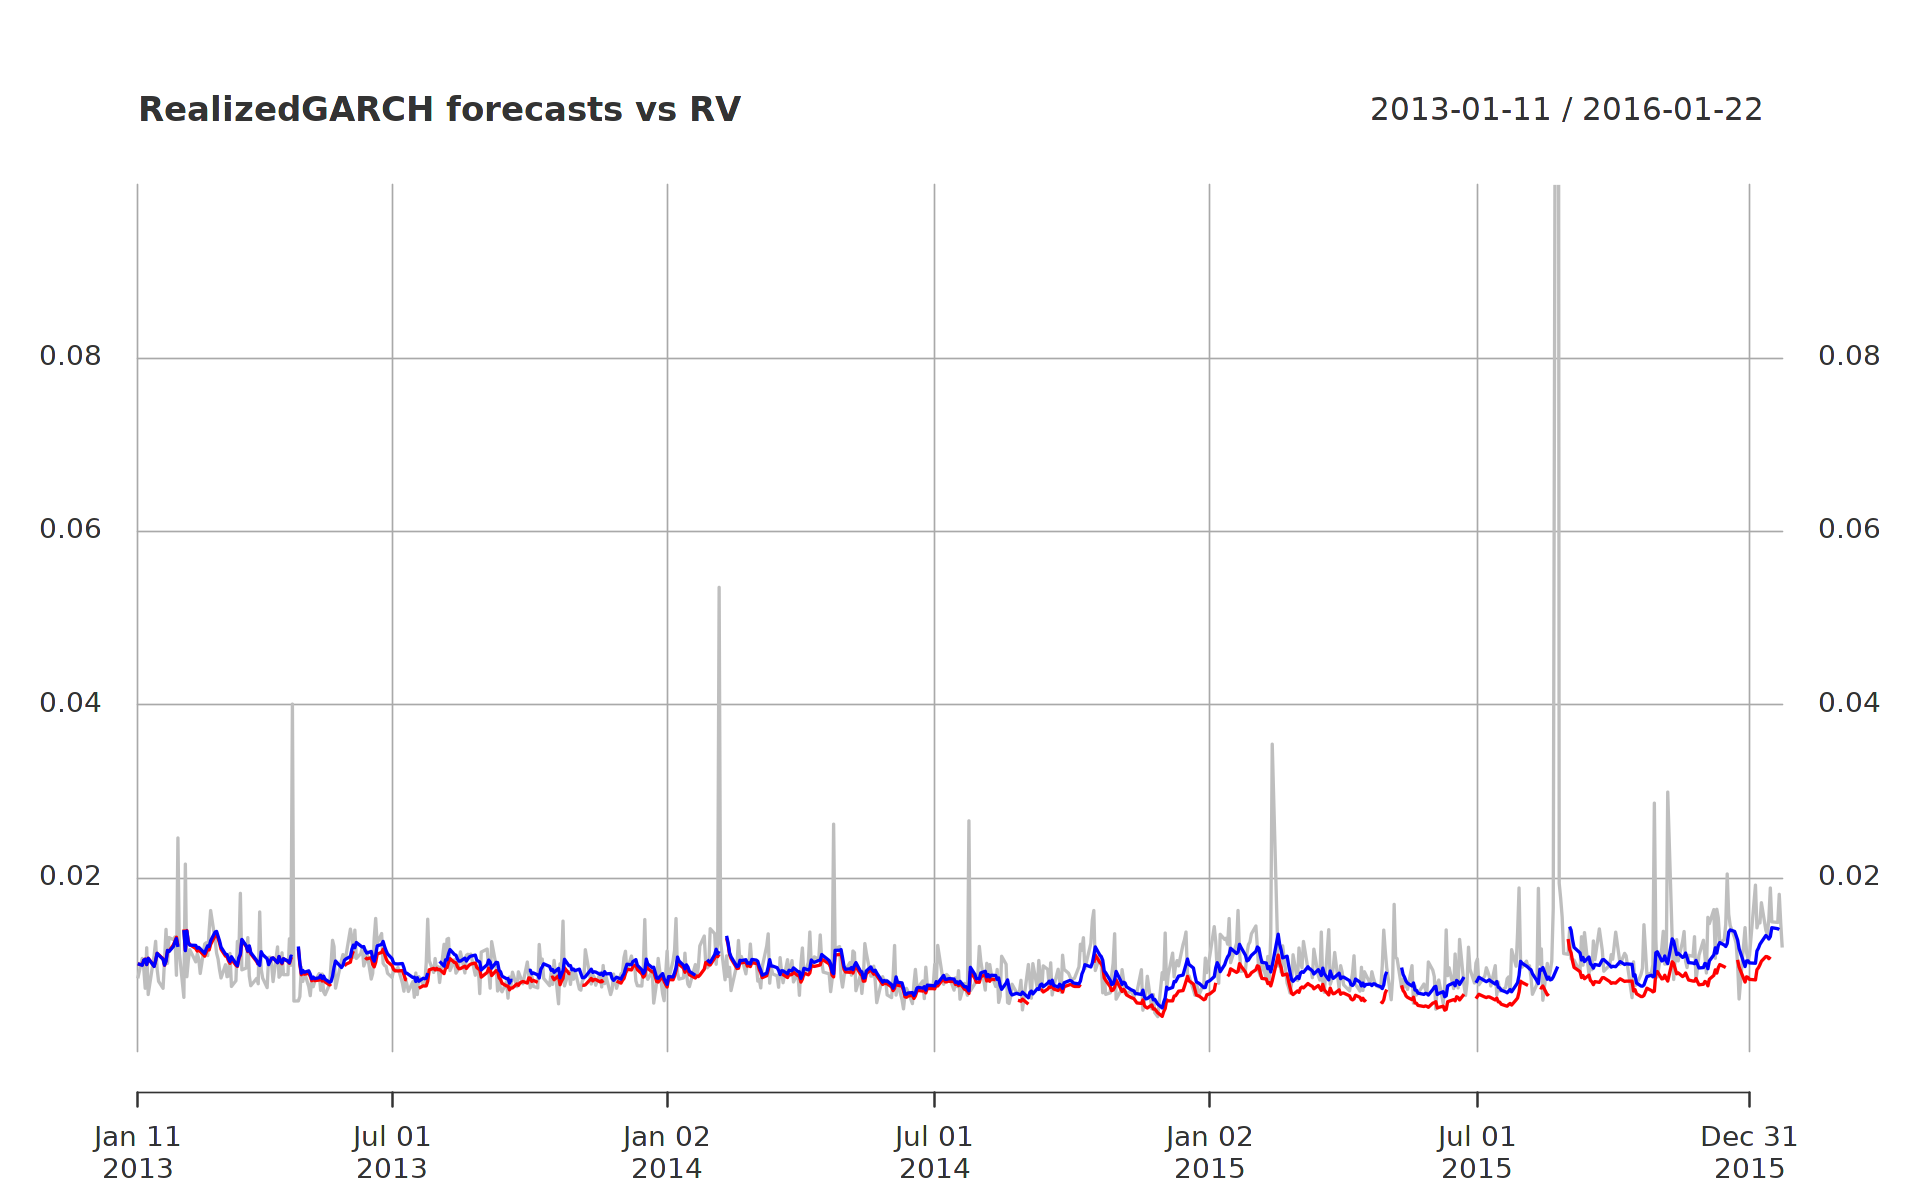

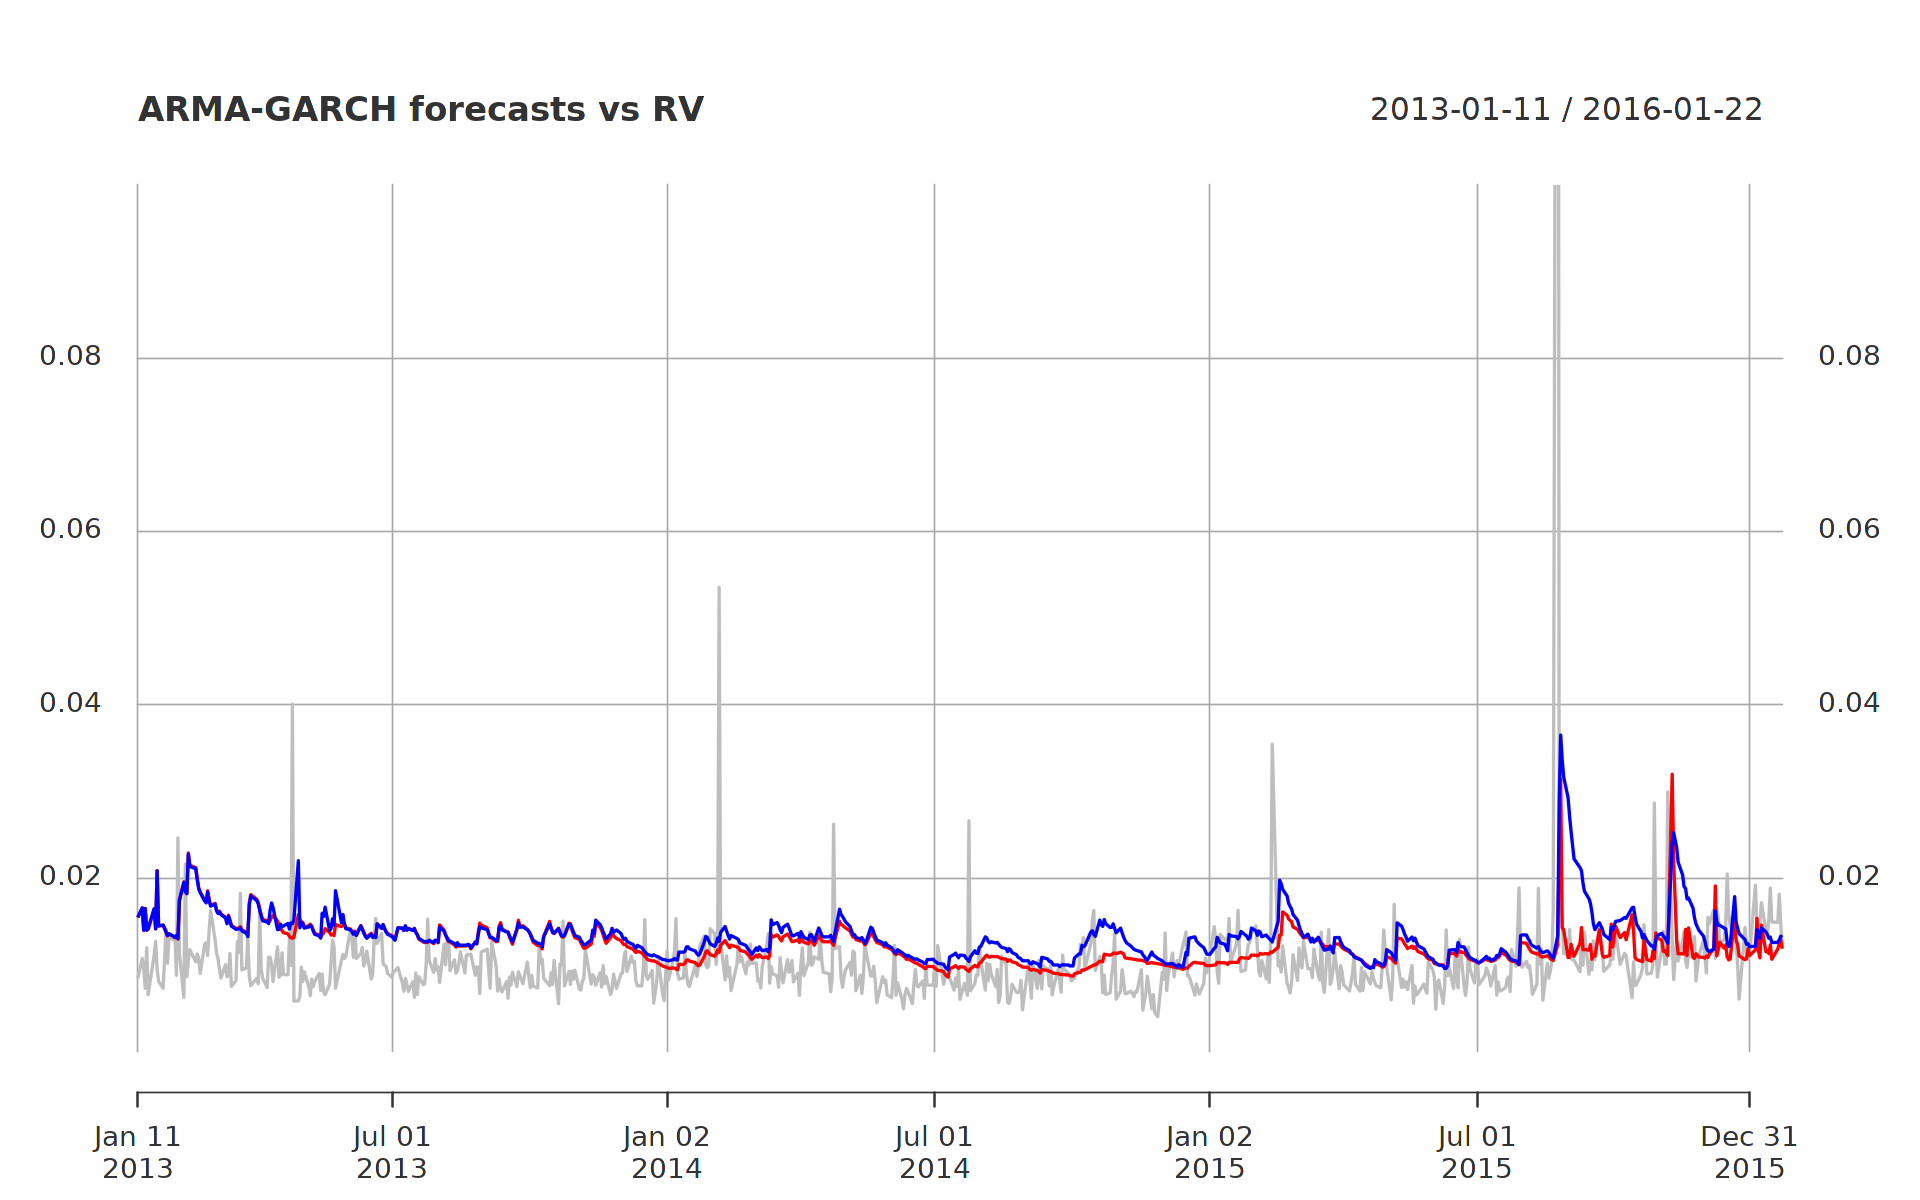

In [ ]:
fcsts_garch <- fcsts_garch %>% as.xts(index(aiz$RV[751:1500]))
  
dat_rg <- merge(
  fcsts_garch[, "forecasts_rec_rg"],
  fcsts_garch[, "forecasts_roll_rg"],
  aiz$RV[751:1500]
)

dat_ag <- merge(
  fcsts_garch[, "forecasts_rec_ag"],
  fcsts_garch[, "forecasts_roll_ag"],
  aiz$RV[751:1500]
)

colnames(dat_rg) <- c("Recursive", "Rolling", "RV")
colnames(dat_ag) <- c("Recursive", "Rolling", "RV")

plot(
  dat_rg,
  main = "RealizedGARCH forecasts vs RV",
  col = c("blue", "red", "gray"),
  lwd = 2,
  legend.loc = "topleft",
  cex = 1,
  ylim = c(0, 0.1)
)

plot(
  dat_ag,
  main = "ARMA-GARCH forecasts vs RV",
  col = c("blue", "red", "gray"),
  lwd = 2,
  legend.loc = "topleft",
  cex = 1,
  ylim = c(0, 0.1)
)

The realized GARCH forecast performed similarly to the other previous forecast, that is, the results look relatively good. However, the GARCH(1,1) forecast did not perform well with both the in-sample and out-of-sample results appearing to be smoothed and underfitted.

### Forecast errors


The forecast errors for all the models are plotted below. To compare the performance of the models, we look to see which forecast error is closest to zero, as the error is calculated as being the difference between the actual and predicted values of the series. In addition, we look to see which graphs have the appearance of having low variability, as this would indicate fewer errors.

In [ ]:
ar_rec_err <- testing_ar - forecasts_rec_ar
ar_roll_err <- testing_ar - forecasts_roll_ar

har_rec_err <- testing_har[, "rv_t0"] - forecasts_rec_har
har_roll_err <- testing_har[, "rv_t0"] - forecasts_roll_har
har_rs_rec_err <- testing_har[, "rv_t0"] - forecasts_rec_har_rs
har_rs_roll_err <- testing_har[, "rv_t0"] - forecasts_roll_har_rs
har_sk_rec_err <- testing_har[, "rv_t0"] - forecasts_rec_har_sk
har_sk_roll_err <- testing_har[, "rv_t0"] - forecasts_roll_har_sk

garch_rg_rec_err <- testing_ar - fcsts_garch[, "forecasts_rec_rg"]
garch_rg_roll_err <- testing_ar - fcsts_garch[, "forecasts_roll_rg"]
garch_ag_rec_err <- testing_ar - fcsts_garch[, "forecasts_rec_ag"]
garch_ag_roll_err <- testing_ar - fcsts_garch[, "forecasts_roll_ag"]

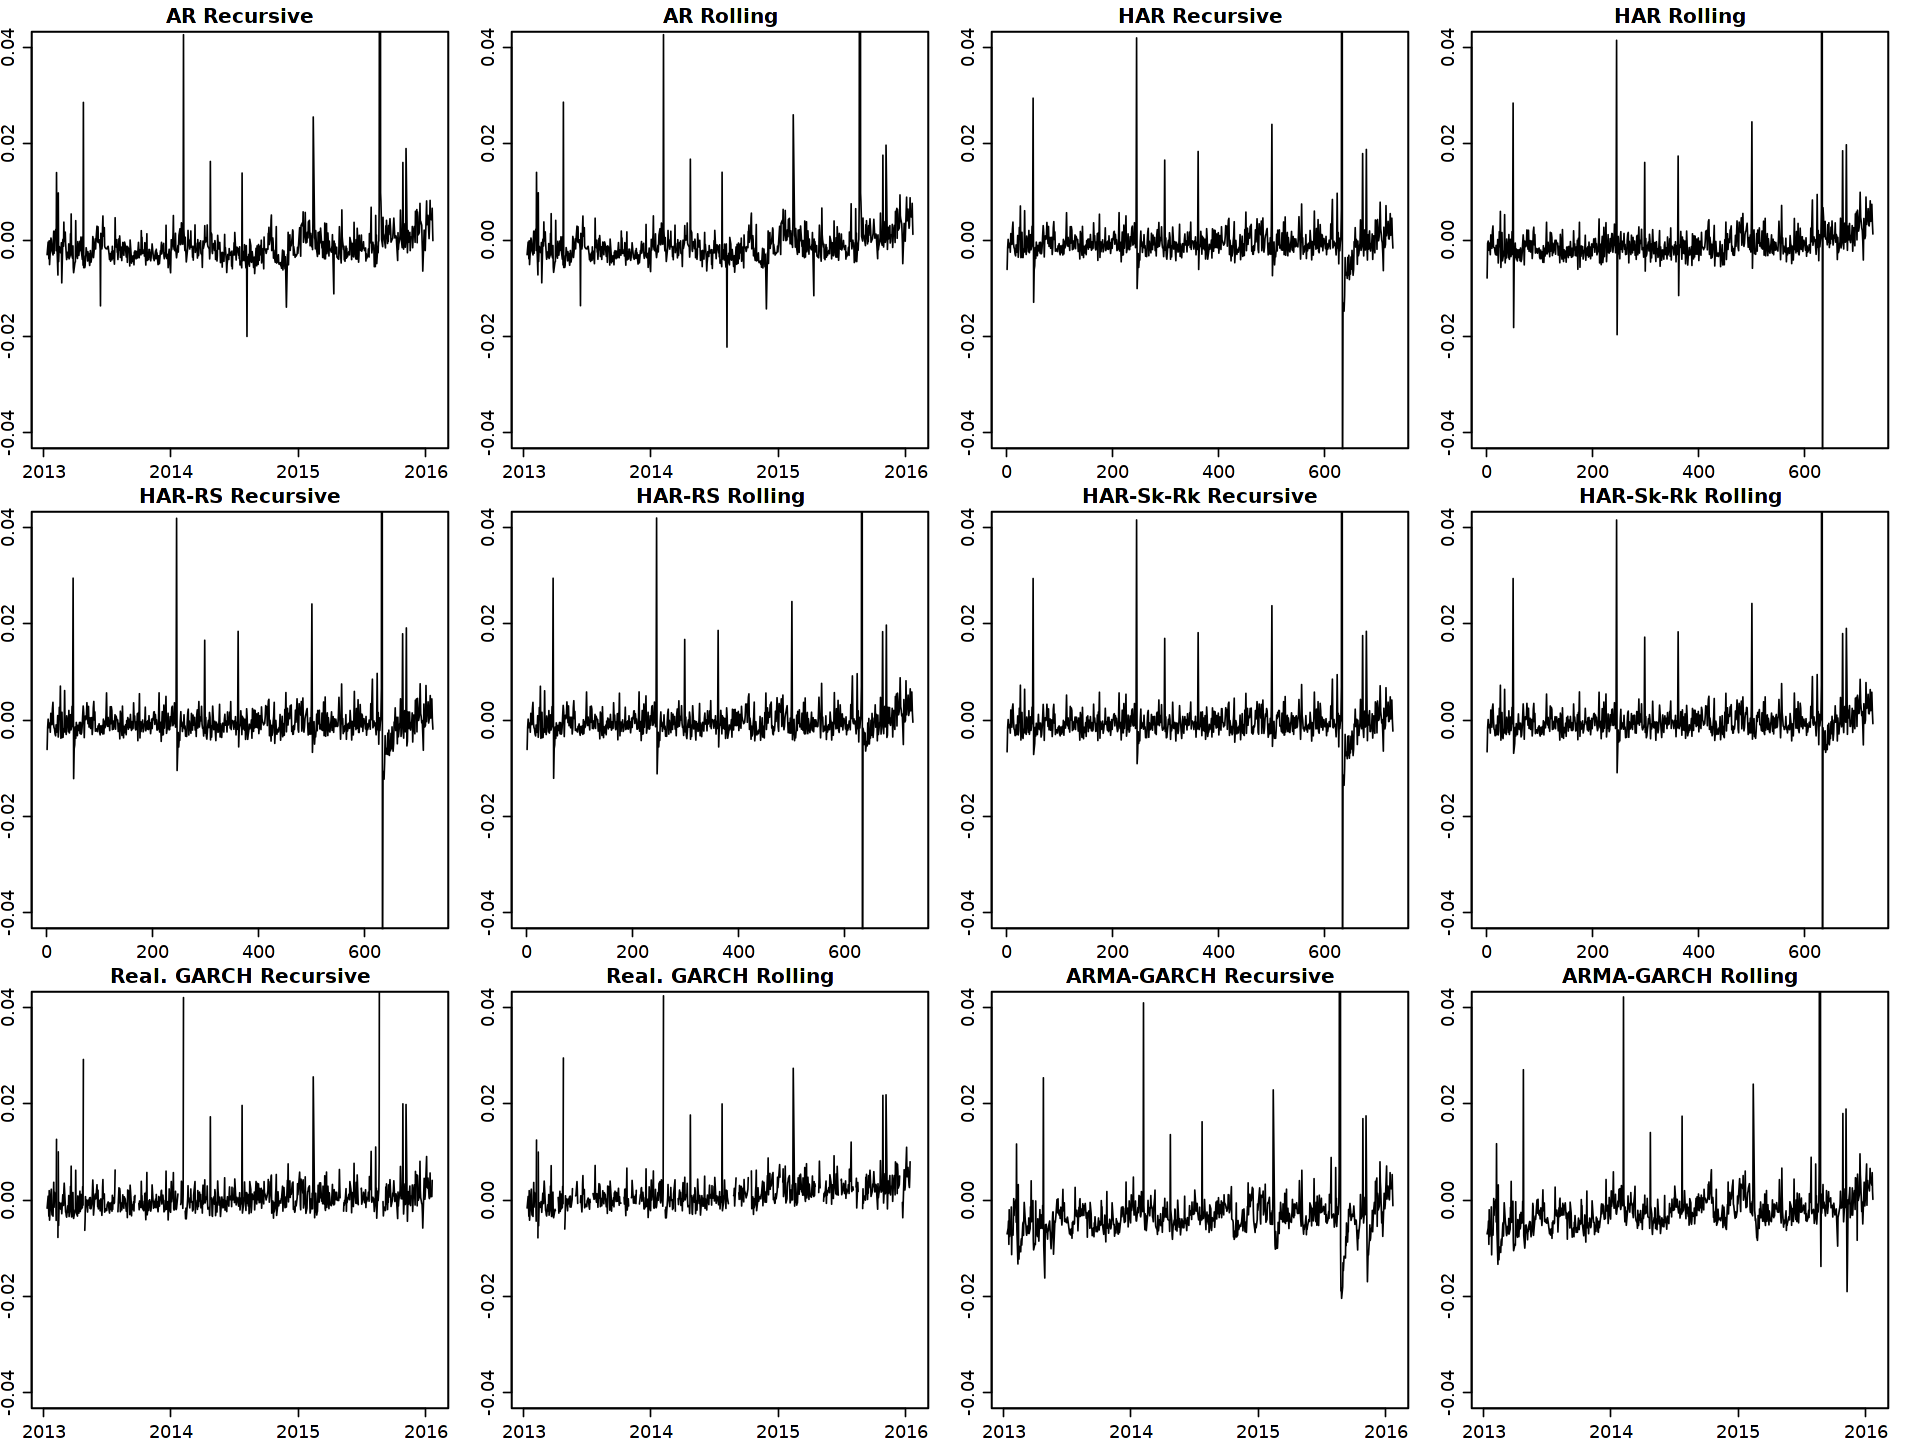

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 12)
par(mfrow = c(3, 4), mar = c(2, 2, 2, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
plot.zoo(ar_rec_err, ylim = c(-0.04, 0.04), main = "AR Recursive")
plot.zoo(ar_roll_err, ylim = c(-0.04, 0.04), main = "AR Rolling")
plot.zoo(har_rec_err, ylim = c(-0.04, 0.04), main = "HAR Recursive")
plot.zoo(har_roll_err, ylim = c(-0.04, 0.04), main = "HAR Rolling")
plot.zoo(har_rs_rec_err, ylim = c(-0.04, 0.04), main = "HAR-RS Recursive")
plot.zoo(har_rs_roll_err, ylim = c(-0.04, 0.04), main = "HAR-RS Rolling")
plot.zoo(har_sk_rec_err, ylim = c(-0.04, 0.04), main = "HAR-Sk-Rk Recursive")
plot.zoo(har_sk_roll_err, ylim = c(-0.04, 0.04), main = "HAR-Sk-Rk Rolling")
plot.zoo(garch_rg_rec_err, ylim = c(-0.04, 0.04), main = "Real. GARCH Recursive")
plot.zoo(garch_rg_roll_err, ylim = c(-0.04, 0.04), main = "Real. GARCH Rolling")
plot.zoo(garch_ag_rec_err, ylim = c(-0.04, 0.04), main = "ARMA-GARCH Recursive")
plot.zoo(garch_ag_roll_err, ylim = c(-0.04, 0.04), main = "ARMA-GARCH Rolling")
par(mfrow = c(1, 1))
options(repr.plot.width = 16, repr.plot.height = 8)

We can quantitatively the performance of the forecasts using the mean square error (MSE) and mean absolute error (MAE). The MSE and MAE are defined as
$$
MSE= k^{-1} \sum^k_{i-1} \hat e^2_{i,t +1 | t}
$$
$$
MAE = k^{-1} \sum^k_{i-1} | \hat e^2_{i,t +1 | t} |
$$

where $\hat e^2_{i,t +1 | t} = y_{t+1} - \hat y_{t+1|t}$ and $k$ is the length of the out-of-sample period.

In [ ]:
mses <- matrix(
  c(
    mean(ar_rec_err^2, na.rm = T),
    mean(ar_roll_err^2, na.rm = T),
    mean(har_rec_err^2, na.rm = T),
    mean(har_roll_err^2, na.rm = T),
    mean(har_rs_rec_err^2, na.rm = T),
    mean(har_rs_roll_err^2, na.rm = T),
    mean(har_sk_rec_err^2, na.rm = T),
    mean(har_sk_roll_err^2, na.rm = T),
    mean(garch_rg_rec_err^2, na.rm = T),
    mean(garch_rg_roll_err^2, na.rm = T),
    mean(garch_ag_rec_err^2, na.rm = T),
    mean(garch_ag_roll_err^2, na.rm = T)
  ),
  ncol = 2,
  byrow = T
)
colnames(mses) <- c("MSE Recursive", "MSE Rolling")
rownames(mses) <- c("AR", "HAR", "HAR-RS", "HAR-RSkew-RKurt", "rGARCH", "ARMA-GARCH")

mses

maes <- matrix(
  c(
    mean(abs(ar_rec_err), na.rm = T),
    mean(abs(ar_roll_err), na.rm = T),
    mean(abs(har_rec_err), na.rm = T),
    mean(abs(har_roll_err), na.rm = T),
    mean(abs(har_rs_rec_err), na.rm = T),
    mean(abs(har_rs_roll_err), na.rm = T),
    mean(abs(har_sk_rec_err), na.rm = T),
    mean(abs(har_sk_roll_err), na.rm = T),
    mean(abs(garch_rg_rec_err), na.rm = T),
    mean(abs(garch_rg_roll_err), na.rm = T),
    mean(abs(garch_ag_rec_err), na.rm = T),
    mean(abs(garch_ag_roll_err), na.rm = T)
  ),
  ncol = 2,
  byrow = T
)
colnames(maes) <- c("MAE Recursive", "MAE Rolling")
rownames(maes) <- c("AR", "HAR", "HAR-RS", "HAR-RSkew-RKurt", "rGARCH", "ARMA-GARCH")

maes

,MSE Recursive,MSE Rolling
AR,8.524182e-05,8.518329e-05
HAR,8.788456e-05,9.183162e-05
HAR-RS,8.792971e-05,9.546370e-05
HAR-RSkew-RKurt,8.891477e-05,9.621665e-05
rGARCH,8.450352e-05,1.601013e-05
ARMA-GARCH,9.568176e-05,8.948866e-05


,MAE Recursive,MAE Rolling
AR,0.003119008,0.003043243
HAR,0.002643806,0.002875656
HAR-RS,0.002628436,0.002591583
HAR-RSkew-RKurt,0.002608548,0.002569045
rGARCH,0.002366408,0.002404966
ARMA-GARCH,0.004488339,0.003811060


Regarding the MSE, the AR model had the lowest error using the rolling window. Regarding the MAE, the realized GARCH, followed closely by the HAR models, using the recursive window had the lowest error. Interestingly, the MSE results show the exact opposite of what we concluded from the visual inspection of the forecasts, that is the AR model apparently had the smallest amount of error. This could possibly be due to the large spike that occured in 2015, which will be discussed at the end. 

Moreover, the worst model for MSE was the HAR-RSkew-RKurt model using the rolling window. Regarding the MAE, the worst model was the GARCH(1,1) model using a recursive window. Once again, the MSE error shows the opposite of what we concluded in the visual inspection of the forecasts. 

In [ ]:
#Diebold-Mariano (DM) test
rows <- c(
    "AR Rec.", "AR Roll.",
    "HAR Rec.", "HAR Roll.",
    "HAR-RS Rec.", "HAR-RS Roll.",
    "HAR-Rs-Rk Rec.", "HAR-Rs-Rk Roll.",
    "rGARCH Rec.", "rGARCH Roll.",
    "ARMA-GARCH Rec.", "ARMA-GARCH Roll."
)

df_dm <- data.frame(matrix(rep(NA, 12 * 12), nrow = 12))
rownames(df_dm) <- rows
colnames(df_dm) <- rows

error_cols <- list(
    as.numeric(ar_rec_err),
    as.numeric(ar_roll_err),
    as.numeric(har_rec_err),
    as.numeric(har_roll_err),
    as.numeric(har_rs_rec_err),
    as.numeric(har_rs_roll_err),
    as.numeric(har_sk_rec_err),
    as.numeric(har_sk_roll_err),
    as.numeric(garch_rg_rec_err),
    as.numeric(garch_rg_roll_err),
    as.numeric(garch_ag_rec_err),
    as.numeric(garch_ag_roll_err)
)

# DM table
for (i in 1:length(error_cols)) {
    for (j in 1:length(error_cols)) {
        if (length(error_cols[[i]]) != length(error_cols[[j]])) {
            # Choose smaller number if lengths are different
            min_length <- min(length(error_cols[[i]]), length(error_cols[[j]]))
            temp_df <- cbind(error_cols[[i]][1:min_length], error_cols[[j]][1:min_length]) %>%
                na.omit()
        } else {
            temp_df <- cbind(error_cols[[i]], error_cols[[j]]) %>%
                na.omit()
        }
        # NA when comparing with self
        if (i == j) {
            df_dm[i, j] <- NA
            next
        }
        dm <- dm.test(temp_df[, 1], temp_df[, 2], alternative = "greater", power = 2)
        df_dm[i, j] <- round(as.numeric(dm$p.value), 4)
    }
}

writeLines("P-values of a one-sided DM test")
df_dm

P-values of a one-sided DM test


,AR Rec.,AR Roll.,HAR Rec.,HAR Roll.,HAR-RS Rec.,HAR-RS Roll.,HAR-Rs-Rk Rec.,HAR-Rs-Rk Roll.,rGARCH Rec.,rGARCH Roll.,ARMA-GARCH Rec.,ARMA-GARCH Roll.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AR Rec.,NA,0.3740,0.5024,0.5181,0.5025,0.5324,0.5065,0.5354,0.0000,0.1381,0.9999,0.9844
AR Roll.,0.6260,NA,0.5031,0.5188,0.5033,0.5331,0.5072,0.5361,0.0000,0.1669,0.9999,0.9849
HAR Rec.,0.4976,0.4969,NA,0.9176,0.5288,0.8163,0.6646,0.7950,0.4803,0.1496,0.5421,0.5160
HAR Roll.,0.4819,0.4812,0.0824,NA,0.0437,0.7379,0.0158,0.7220,0.4649,0.1390,0.5259,0.4999
HAR-RS Rec.,0.4975,0.4967,0.4712,0.9563,NA,0.8324,0.7053,0.8082,0.4801,0.1489,0.5419,0.5158
HAR-RS Roll.,0.4676,0.4669,0.1837,0.2621,0.1676,NA,0.1431,0.6593,0.4505,0.1300,0.5111,0.4854
HAR-Rs-Rk Rec.,0.4935,0.4928,0.3354,0.9842,0.2947,0.8569,NA,0.8262,0.4760,0.1447,0.5380,0.5118
HAR-Rs-Rk Roll.,0.4646,0.4639,0.2050,0.2780,0.1918,0.3407,0.1738,NA,0.4474,0.1268,0.5081,0.4823
rGARCH Rec.,1.0000,1.0000,0.5197,0.5351,0.5199,0.5495,0.5240,0.5526,NA,1.0000,1.0000,1.0000


Soley based on the p-values in the table, we can see that the AR model using both the recursive and rolling windows out performed both GARCH(1,1) models, HAR-RSkew and HAR-RSkew-RKurt with recursive window performed better than HAR with rolling window, and realized GARCH with rolling window performed better than GARCH(1,1) with recursive window. None of the other p-values indiciate superiority of one model over another.

In [ ]:
# Minzer-Zarnowitz
lm_objects <- list(
    mz_ar_rec <- lm(testing_ar ~ forecasts_rec_ar),
    mz_ar_roll <- lm(testing_ar ~ forecasts_roll_ar),
    mz_har_rec <- lm(testing_har[, "rv_t0"] ~ forecasts_rec_har),
    mz_har_roll <- lm(testing_har[, "rv_t0"] ~ forecasts_roll_har),
    mz_harrs_rec <- lm(testing_har[, "rv_t0"] ~ forecasts_rec_har_rs),
    mz_harrs_roll <- lm(testing_har[, "rv_t0"] ~ forecasts_roll_har_rs),
    mz_harsk_rec <- lm(testing_har[, "rv_t0"] ~ forecasts_rec_har_sk),
    mz_harsk_roll <- lm(testing_har[, "rv_t0"] ~ forecasts_roll_har_sk),
    mz_rg_rec <- lm(testing_ar ~ fcsts_garch[, "forecasts_rec_rg"]),
    mz_rg_roll <- lm(testing_ar ~ fcsts_garch[, "forecasts_roll_rg"]),
    mz_ag_rec <- lm(testing_ar ~ fcsts_garch[, "forecasts_rec_ag"]),
    mz_ag_roll <- lm(testing_ar ~ fcsts_garch[, "forecasts_roll_ag"])
)

perform_wald_test <- function(lm) {
    wald <- wald.test(b = coef(lm), Sigma = vcov(lm), H0 = c(0, 1), Terms = 1:2)
    coefs <- coef(lm)
    return(c(coefs, wald$result$chi2[1], round(wald$result$chi2[3], 2)))
}

# Empty dataframe for results
df <- as.data.frame(matrix(rep(NA, 5 * 12), ncol = 5))
cols <- c("Intercept", "Slope", "Statistic", "P-value", "R-squared")

rownames(df) <- rows
colnames(df) <- cols

for (i in 1:length(lm_objects)) {
    df[i, ] <- c(perform_wald_test(lm_objects[[i]]), summary(lm_objects[[i]])$r.squared)
}

df

,Intercept,Slope,Statistic,P-value,R-squared
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AR Rec.,0.012584145,-0.2013186,31.713394,0.00,0.0009473801
AR Roll.,0.012641433,-0.2111504,31.329710,0.00,0.0011418400
HAR Rec.,0.006935235,0.3171758,46.438505,0.00,0.0133610016
HAR Roll.,0.008611064,0.1564206,73.012933,0.00,0.0033377067
HAR-RS Rec.,0.006914575,0.3192961,47.229093,0.00,0.0138634443
HAR-RS Roll.,0.008446742,0.1789629,107.673912,0.00,0.0069944618
HAR-Rs-Rk Rec.,0.006957231,0.3144974,57.736287,0.00,0.0161847489
HAR-Rs-Rk Roll.,0.008290056,0.1943869,116.141861,0.00,0.0092260611
rGARCH Rec.,0.003091740,0.7603334,7.072614,0.03,0.0198768375


At a 99% CI, the realized GARCH model with recursive window was the only model where we cannot reject the null hypothesis. Additionally, it is important to note the small R-squared values, which in combination indicates relatively poor performance of the forecasts. This is important to note though because our original visual analysis of the forecasts looked relatively performant, but these discrepencies will be discussed in the summary.  

## Summary

In conclusion, when we consider the in-sample fit models conducted in this study we found that the AR(1)-RV model was able to establish a relationship at the first lag but when considering the acf and pacf test of the residual we still observe some evidence for autocorrelation, Henceforth we conducted the HAR model to study additional lags. In particular we found there to be statistically significant results from which we concluded that investors are more likely to engage in trading the stock on a monthly basis rather than on a weekly basis. Furthermore we studied the HAR-RS model where positive and negative semi-volatility was taken into account seperately. From this model we found the negative semi-volatility to have a much greater effect and interestingly we found the difference between positive - and negative semi-volatility to be statistically significant. Additionally, we also found evidence to support the existence of the leverage effect in our data sample. Furthermore, the HAR-Rskew-Rkurt model thought us that the influence of jumps caused caused the kurtosis variable to have a negative coefficient with statistical significance in our sample. In other words, as the distribution of the variable becomes more platykurtic (flatter and less peaked), it is associated with lower values of the realized volatility. The realized GARCH model explains that the $\alpha_1$ value in particular has a coefficient of 1 representing the effect of log of past of realized volatility. The ARMA-GARCH model was arguably the least successfully fit model due to the adjusted r-squared and RMSE values. Nevertheless, it showed a particularly large $\beta_1$ value and potentially indicating a potentially unit root relationship. Ultimately, when comparing the models we found the HAR models to be exhibiting the best fitted values. On the other hand, the GARCH(1,1) model illustrated the worst goodness of fit.

Regarding the out-of-sample forecasting performance, upon visual inspection the realized GARCH and the HAR family of models looked to be the most accurate. However, after calculating the errors and comparing the models using the DM test and MZ regression, we found that the results showed a very different story, with the AR model having a relatively small error compared to the other models and the smallest error when using the MSE function although visually appearing to be non-performant in the forecast. We believe this discrepency is due to the 2015–2016 stock market selloff, which appears to have unproportionally effected the RV around August of 2015, and as a result skewed the variability in the errors as seen in the comparison plot. This massive spike in volatility likely caused some of the convergence errors that were experienced and likely skewed the results of the forecasting errors and MZ regression in particular. 